In [1]:
import pandas as pd
import collections

import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import seaborn as sns

import pickle

import json

import requests

n_clusters = 4

In [2]:
plt.style.use('seaborn')

In [3]:
loans_samples_reduced = pd.read_csv('final_reduced_dataset.csv')

In [4]:
loans_samples_reduced = loans_samples_reduced.set_index('loan_id')

In [5]:
loans_samples_reduced['borrower_count'] = loans_samples_reduced['female_count']+loans_samples_reduced['male_count']

In [6]:
# Stratified Sampling by country and sectors

loans_samples = loans_samples_reduced.groupby(['sector_name'], group_keys=False).apply(lambda x: x.sample(min(len(x), 1200)))

loans_samples = loans_samples.reset_index(drop=True)

loans_samples.shape

(17663, 20)

In [7]:
def getFeatureVector(dataset):
    
    X = dataset[['loan_amount', 'status', 'activity_name', 'sector_name','borrower_count','mpi', 'population_in_mpi',
                 'Education', 'Health', 'Living standards', 'population_in_severe_mpi']]

    dataset_dummies = pd.get_dummies(X)

    scaler = StandardScaler()

    scaler.fit(dataset_dummies)

    data_scaled = scaler.transform(dataset_dummies)

    feature = pd.DataFrame(data_scaled)

    feature.columns = dataset_dummies.columns
    
    return feature

In [8]:
features_df = getFeatureVector(loans_samples)

features_df.head()

,loan_amount,borrower_count,mpi,population_in_mpi,Education,Health,Living standards,population_in_severe_mpi,status_funded,activity_name_Agriculture,...,sector_name_Entertainment,sector_name_Food,sector_name_Health,sector_name_Housing,sector_name_Manufacturing,sector_name_Personal Use,sector_name_Retail,sector_name_Services,sector_name_Transportation,sector_name_Wholesale
0,0.655592,-0.235027,-0.843941,-0.837470,-1.473000,2.062142,-0.769538,-0.847527,0.0,-0.090344,...,-0.244976,-0.269983,-0.269983,-0.269983,-0.269983,-0.269983,-0.269983,-0.269983,-0.269983,-0.253054
1,-0.342029,-0.235027,-0.826518,-0.911427,0.855193,-0.092741,-0.718856,-0.605614,0.0,-0.090344,...,-0.244976,-0.269983,-0.269983,-0.269983,-0.269983,-0.269983,-0.269983,-0.269983,-0.269983,-0.253054
2,-0.231183,-0.235027,-0.739404,-0.721912,-0.835139,-0.131221,0.933364,-0.774953,0.0,-0.090344,...,-0.244976,-0.269983,-0.269983,-0.269983,-0.269983,-0.269983,-0.269983,-0.269983,-0.269983,-0.253054
3,0.323052,0.795581,0.192723,0.359708,0.376797,-0.458301,0.122458,-0.025024,0.0,-0.090344,...,-0.244976,-0.269983,-0.269983,-0.269983,-0.269983,-0.269983,-0.269983,-0.269983,-0.269983,-0.253054
4,-0.674570,-0.235027,-0.826518,-0.911427,0.855193,-0.092741,-0.718856,-0.605614,0.0,-0.090344,...,-0.244976,-0.269983,-0.269983,-0.269983,-0.269983,-0.269983,-0.269983,-0.269983,-0.269983,-0.253054


In [9]:
def applyPCA(n,features):
    pca = PCA(n_components=n) #n-dimensional PCA
    principal_df = pd.DataFrame(pca.fit_transform(features))
    
    # Identifying the significant features of final PCA components
    
    PCA_stats = pd.DataFrame(pca.components_,columns=features.columns,index = range(0,n)).transpose()
    print(f"PCA transformation applied with {n} components:")
    print("\nTop 5 features in each principal component")
    print([PCA_stats[c].nlargest(5) for c in PCA_stats])
    print('-----------------------------------------------')
    
    return principal_df

In [10]:
applyPCA(3,features_df)

PCA transformation applied with 3 components:

Top 5 features in each principal component
[population_in_mpi           0.489558
mpi                         0.486043
population_in_severe_mpi    0.459972
Living standards            0.266448
borrower_count              0.141952
Name: 0, dtype: float64, sector_name_Personal Use         0.369158
activity_name_Home Appliances    0.322743
Education                        0.310334
borrower_count                   0.178891
sector_name_Housing              0.162809
Name: 1, dtype: float64, sector_name_Personal Use         0.446063
activity_name_Home Appliances    0.366619
borrower_count                   0.259209
sector_name_Education            0.190805
Health                           0.183302
Name: 2, dtype: float64]
-----------------------------------------------


,0,1,2
0,-2.100334,-0.823851,1.839282
1,-1.449619,0.639779,1.156099
2,-1.062638,-0.078801,1.205101
3,0.380004,0.266356,1.354689
4,-2.012015,0.502946,1.269664
5,-1.443724,0.685552,1.182022
6,3.355000,0.041569,0.905606
7,-1.248794,-0.700529,1.001553
8,2.899870,-1.191478,1.300234
9,-1.039058,0.104290,1.308790


In [11]:
# Assuming 3 components on PCA - plot the clusters

def plotClusters(n,transformed):
    
    colors = ['#2f7ed8', '#0d233a', '#8bbc21', '#910000', '#1aadce', '#492970', '#f28f43', '#77a1e5', '#c42525', '#a6c96a']
    
    
    
    for i in range(n): 
        
        plt.title('View in pair of 2 Dimensions')
        
        ax = plt.subplot(1,3,1)
        ax.scatter(transformed[transformed['y']==i][0],  
                   transformed[transformed['y']==i][1],  
                   label=f'Class {i}', 
                   c=colors[i])
        ax = plt.subplot(1,3,2)
        ax.scatter(transformed[transformed['y']==i][1],  
                   transformed[transformed['y']==i][2],  
                   label=f'Class {i}', 
                   c=colors[i])
        ax = plt.subplot(1,3,3)
        ax.scatter(transformed[transformed['y']==i][0],  
                   transformed[transformed['y']==i][2],  
                   label=f'Class {i}', 
                   c=colors[i])
   
    
    fig = plt.figure(figsize=(8,8))
    ax = p3.Axes3D(fig)
    
    for i in range(n):
        ax.scatter(transformed[transformed['y']==i][0],  
                   transformed[transformed['y']==i][2], 
                   transformed[transformed['y']==i][1],  
                   label=f'Class {i}', 
                   c=colors[i])
        
    plt.title('View in 3 Dimensions')
    
    
    plt.legend()
    plt.show()


In [12]:
# Sticking with 3 component PCA to help visualize the clusters

pca_transformed = applyPCA(3,features_df)

all_cluster_stats = pd.DataFrame()    

PCA transformation applied with 3 components:

Top 5 features in each principal component
[population_in_mpi           0.489766
mpi                         0.486294
population_in_severe_mpi    0.460354
Living standards            0.265976
borrower_count              0.142316
Name: 0, dtype: float64, Education                                  0.325436
sector_name_Personal Use                   0.315855
activity_name_Home Appliances              0.281131
sector_name_Housing                        0.187783
activity_name_Personal Housing Expenses    0.187090
Name: 1, dtype: float64, sector_name_Personal Use         0.422242
activity_name_Home Appliances    0.346104
borrower_count                   0.241933
activity_name_Home Energy        0.172158
sector_name_Agriculture          0.168983
Name: 2, dtype: float64]
-----------------------------------------------


In [13]:
k_silhouette_scores = []

k_interia_scores = []

for k in range(2,10):
    
    kmeans = KMeans(n_clusters=k, random_state=0).fit(pca_transformed)

    label = kmeans.labels_

    print(f"\nCluster sizes of {k} clusters: \n\t {collections.Counter(label)}")
   
    silhouette_avg = silhouette_score(pca_transformed, label)
    inertia_value = (kmeans.inertia_/k)
    
    k_silhouette_scores.append(silhouette_avg)
    k_interia_scores.append(inertia_value)
    
    print("\nThe average silhouette_score is :", silhouette_avg,
          "\nThe mean intra cluster distance is :", inertia_value)



Cluster sizes of 2 clusters: 
	 Counter({1: 9495, 0: 8168})

The average silhouette_score is : 0.307447686861 
The mean intra cluster distance is : 50990.4761468

Cluster sizes of 3 clusters: 
	 Counter({0: 9584, 1: 6829, 2: 1250})

The average silhouette_score is : 0.364324445599 
The mean intra cluster distance is : 24773.7440526

Cluster sizes of 4 clusters: 
	 Counter({3: 7069, 2: 6565, 0: 2781, 1: 1248})

The average silhouette_score is : 0.400120656812 
The mean intra cluster distance is : 12742.9909142

Cluster sizes of 5 clusters: 
	 Counter({0: 5771, 3: 5718, 1: 2489, 4: 2448, 2: 1237})

The average silhouette_score is : 0.354024699936 
The mean intra cluster distance is : 8450.79687623

Cluster sizes of 6 clusters: 
	 Counter({0: 5545, 1: 3556, 5: 3164, 4: 2180, 2: 1981, 3: 1237})

The average silhouette_score is : 0.348071873843 
The mean intra cluster distance is : 6049.00352952

Cluster sizes of 7 clusters: 
	 Counter({0: 3412, 2: 3199, 6: 3135, 1: 3123, 5: 1940, 4: 1631,

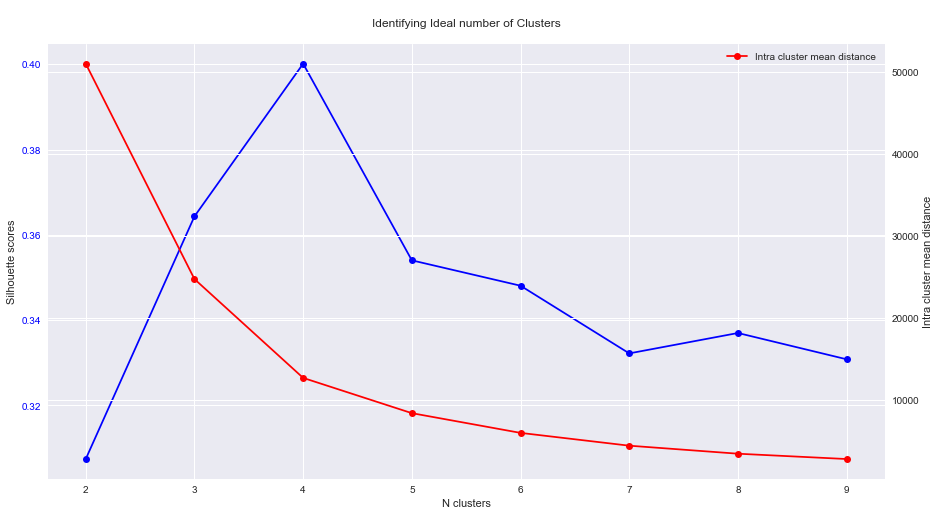

In [14]:


plt.figure(figsize=(15, 8))
ax1 = plt.subplot(1, 1, 1)

ax1.plot(range(2,10),k_silhouette_scores,marker='o',color='blue', label='Silhouette scores')

ax1.set_xlabel('N clusters')
ax1.set_ylabel('Silhouette scores')
ax1.tick_params('y', colors='b')


ax2 = ax1.twinx()

ax2.plot(range(2,10),k_interia_scores,marker='o',color='red', label='Intra cluster mean distance')
ax2.set_ylabel('Intra cluster mean distance', )

plt.title('\nIdentifying Ideal number of Clusters\n')

plt.savefig('Identifying_optimal_K.png')


plt.legend()
plt.show()

PCA transformation applied with 4 components:

Top 5 features in each principal component
[population_in_mpi           0.489502
mpi                         0.485929
population_in_severe_mpi    0.459863
Living standards            0.269976
borrower_count              0.140355
Name: 0, dtype: float64, sector_name_Personal Use                   0.331962
Education                                  0.311861
activity_name_Home Appliances              0.288933
sector_name_Housing                        0.187090
activity_name_Personal Housing Expenses    0.185182
Name: 1, dtype: float64, sector_name_Personal Use         0.473804
activity_name_Home Appliances    0.387641
borrower_count                   0.280400
activity_name_Home Energy        0.194408
sector_name_Agriculture          0.182950
Name: 2, dtype: float64, sector_name_Construction               0.428187
activity_name_Construction Supplies    0.238644
activity_name_Construction             0.218514
Living standards                   

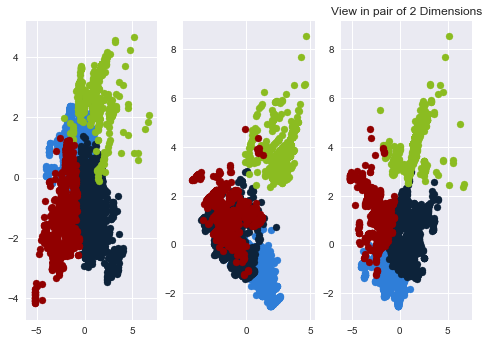

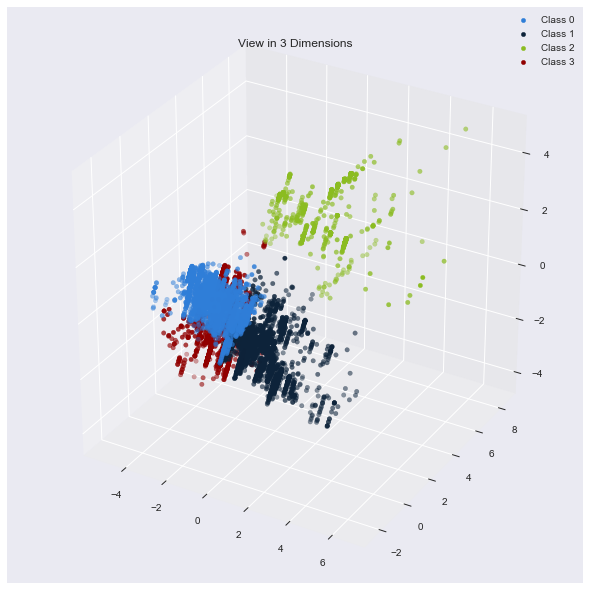


Test Sample


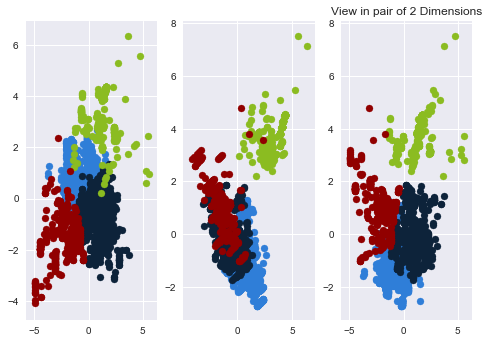

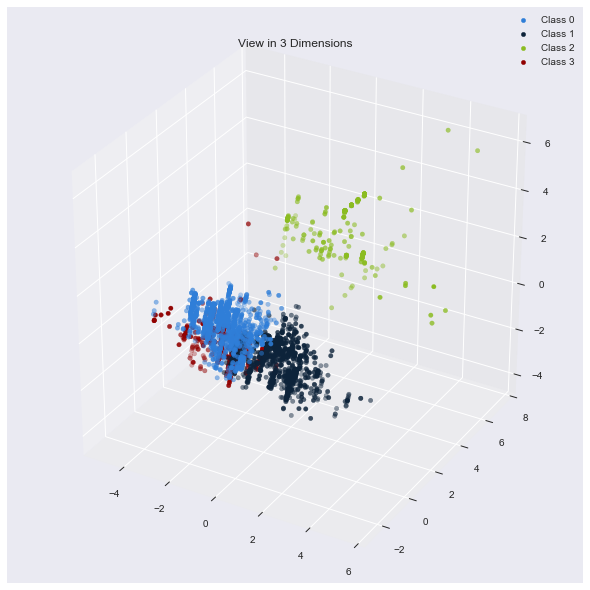

C:\Users\ssank\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\ssank\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Training Sample - Describing categorical

-----------------------------------------------


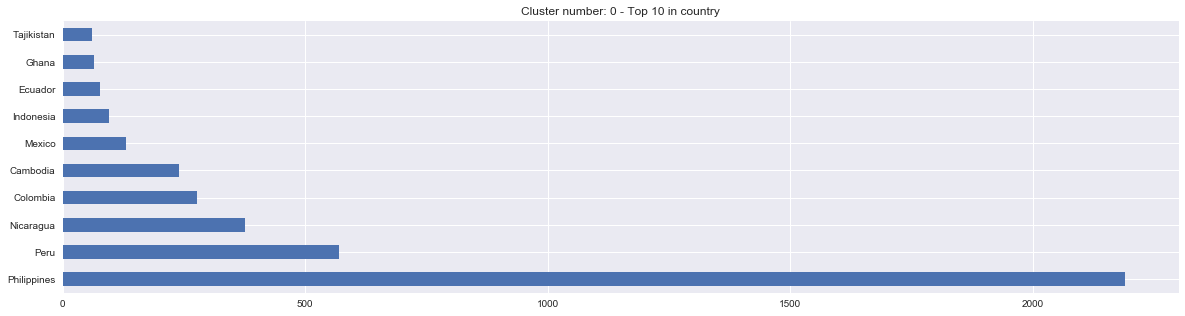

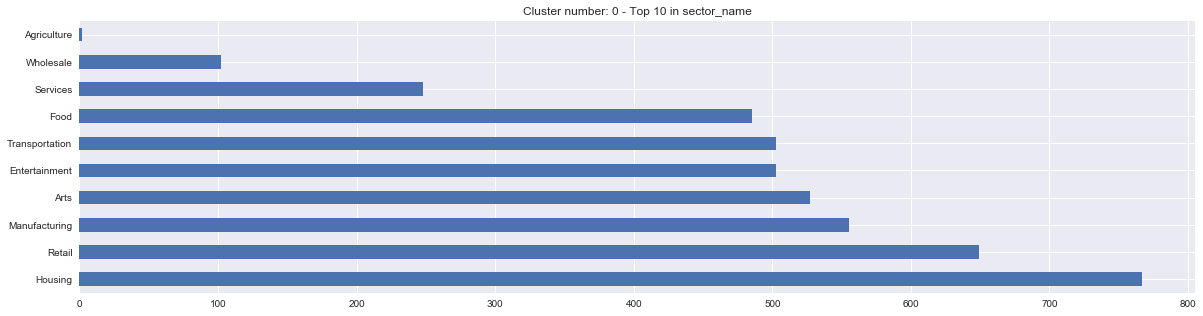

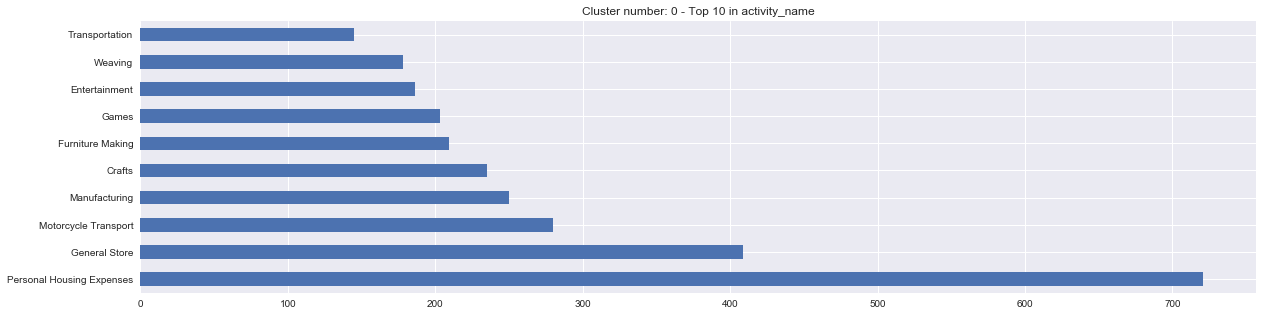

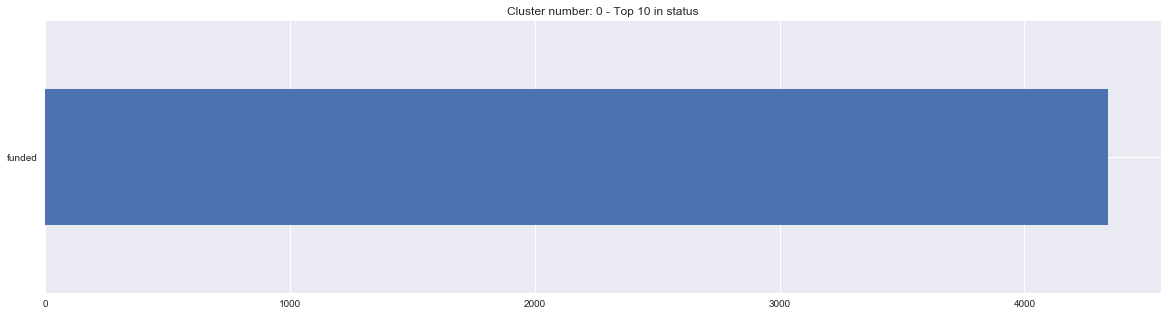

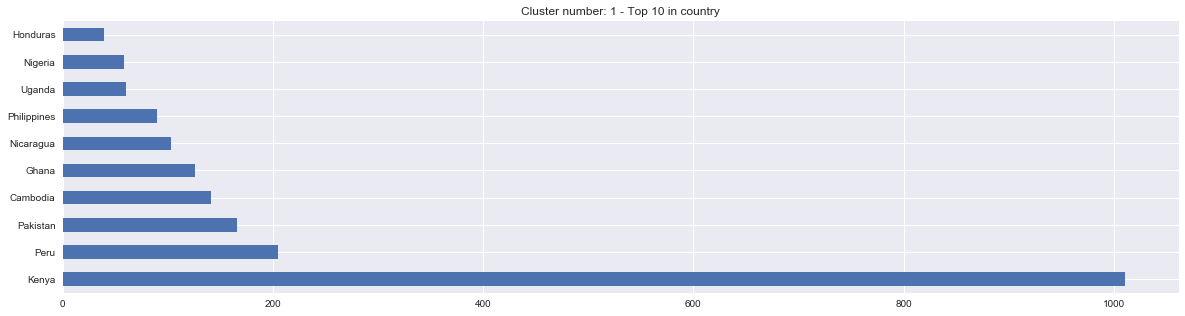

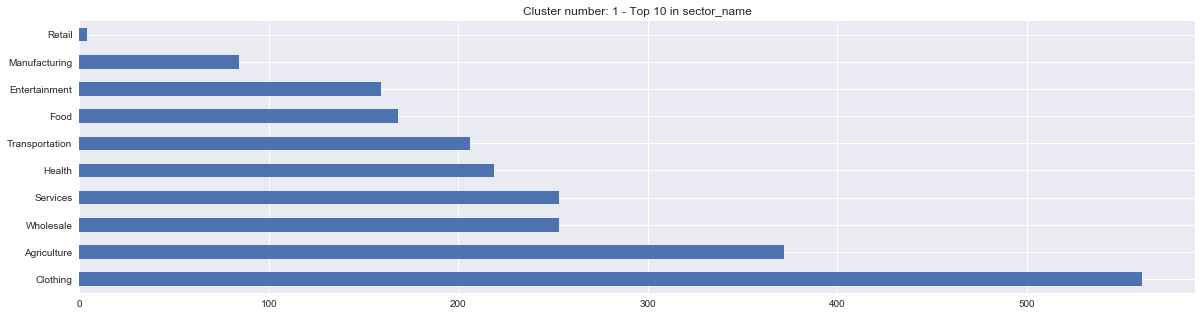

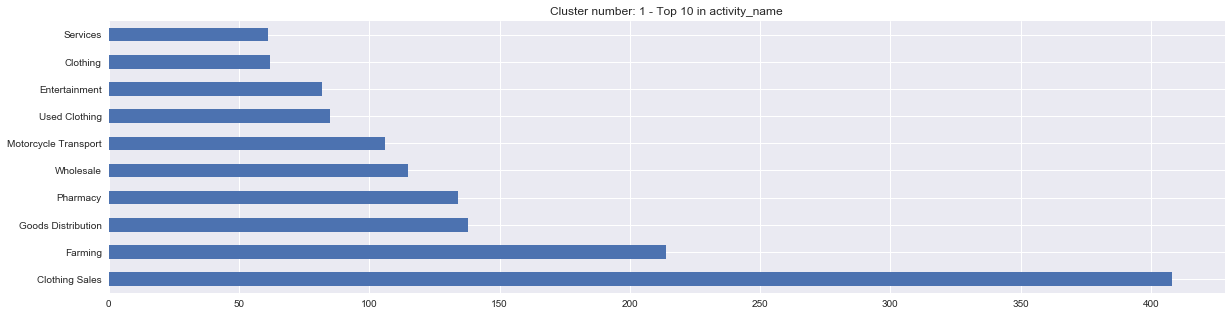

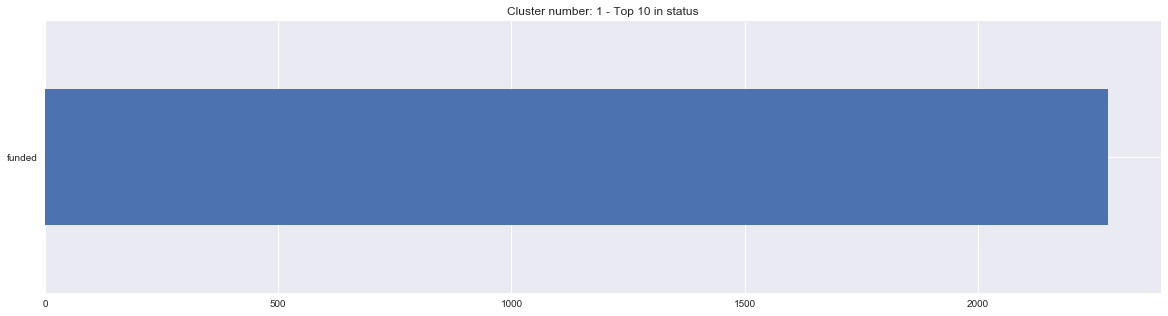

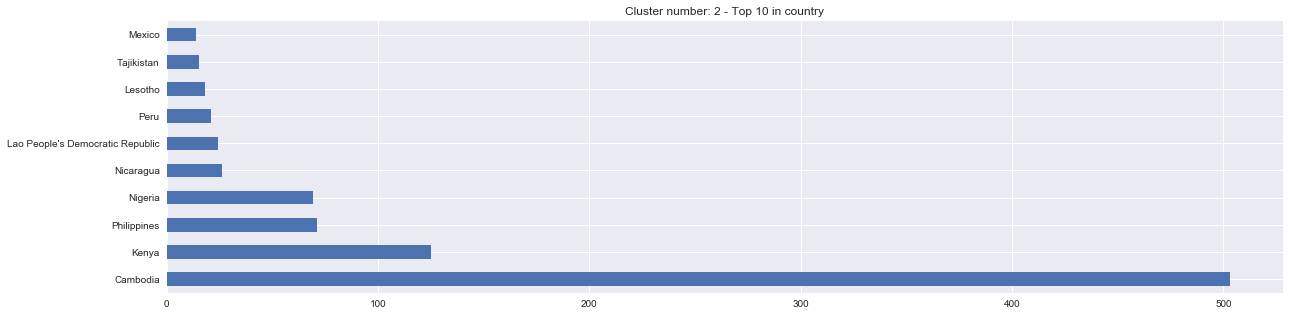

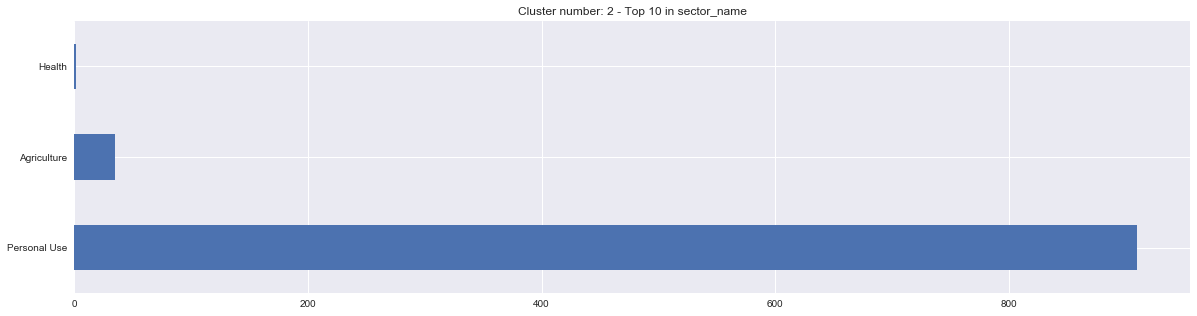

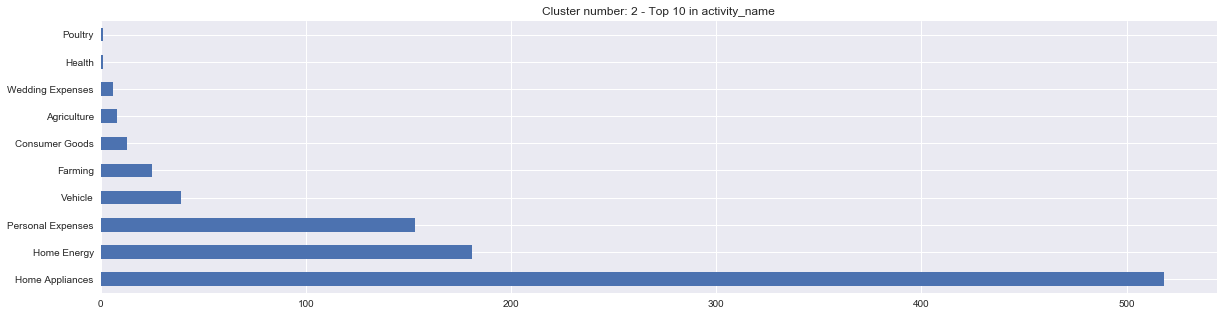

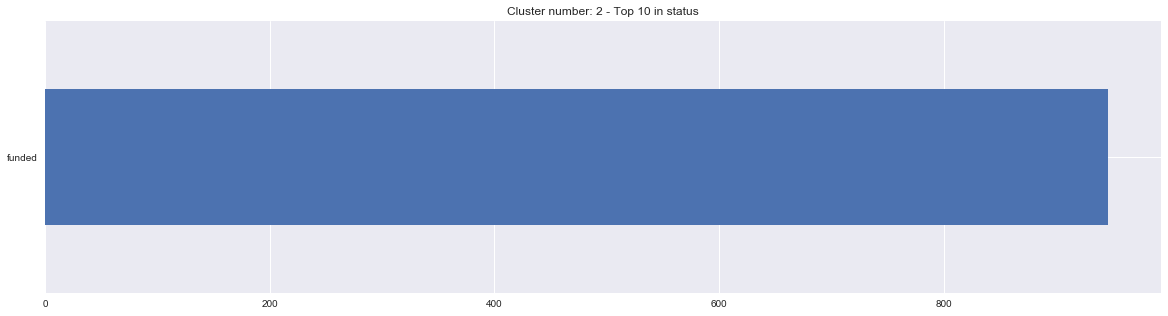

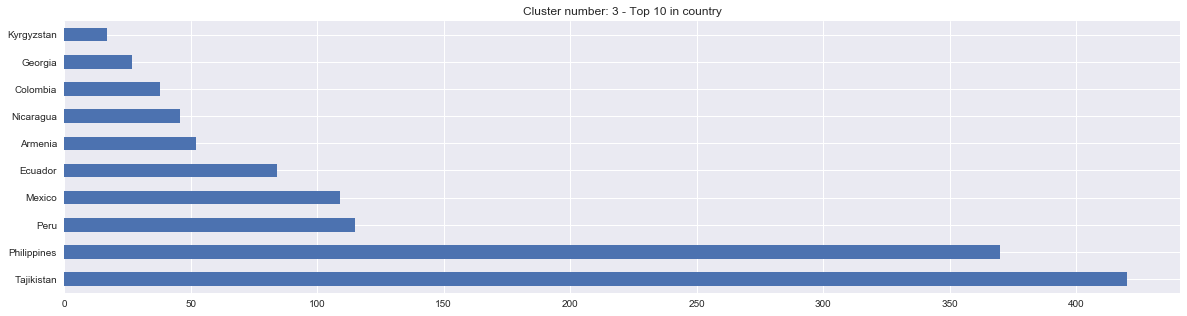

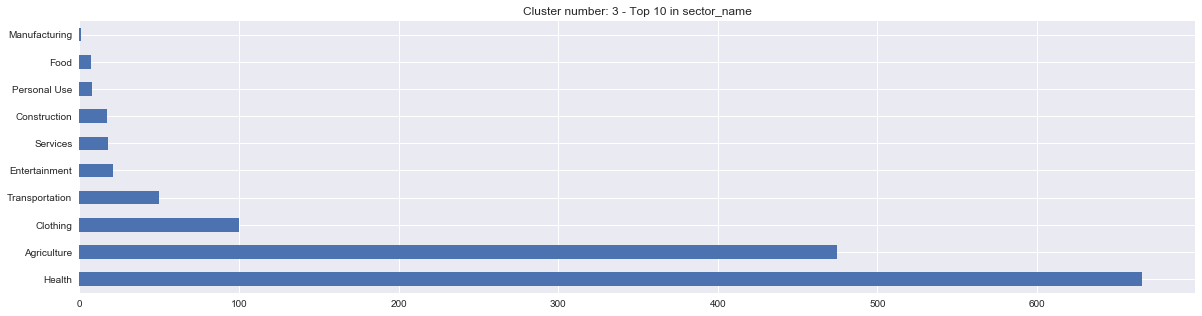

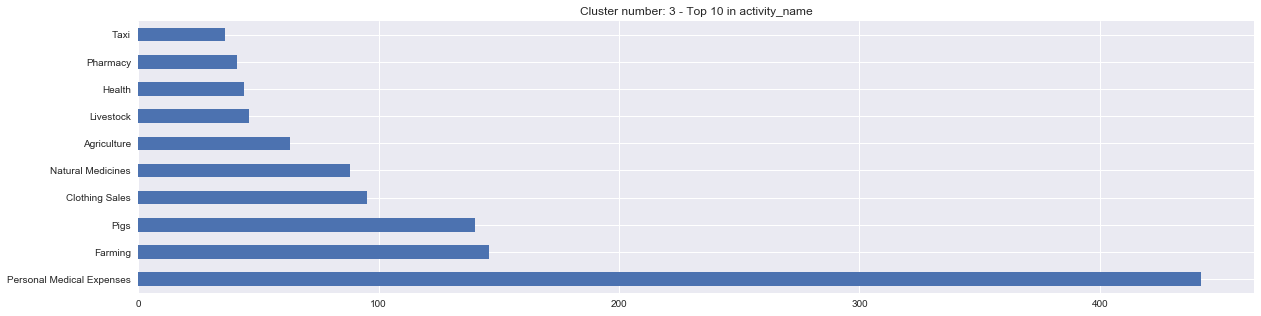

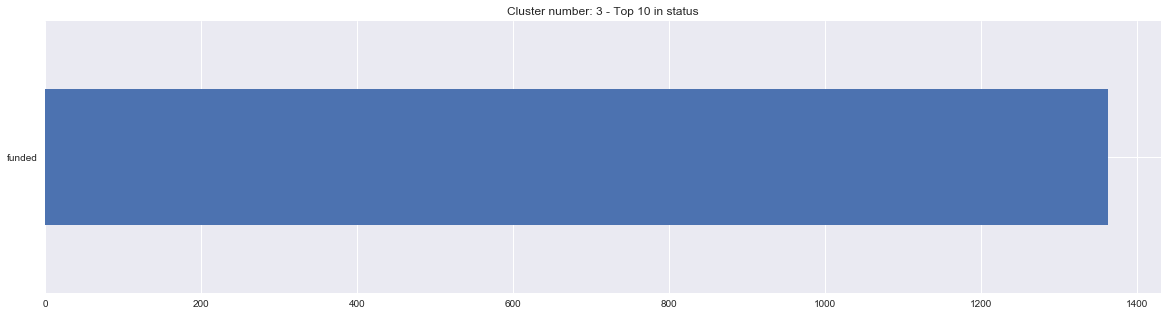


Test Sample - Describing categorical

-----------------------------------------------


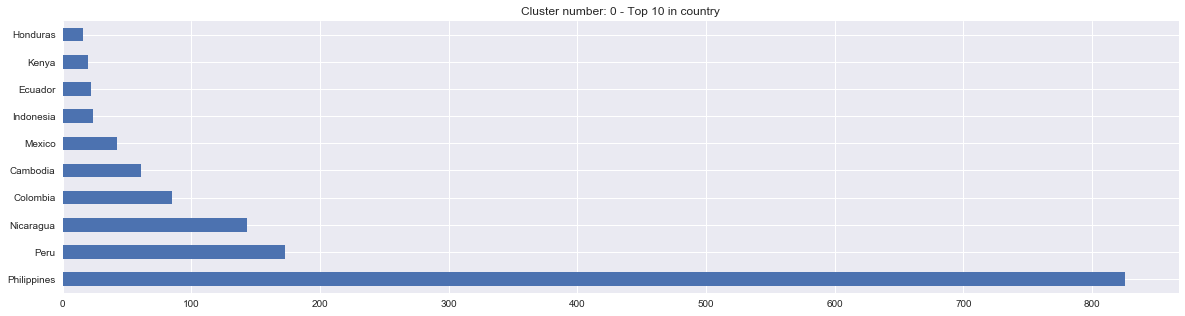

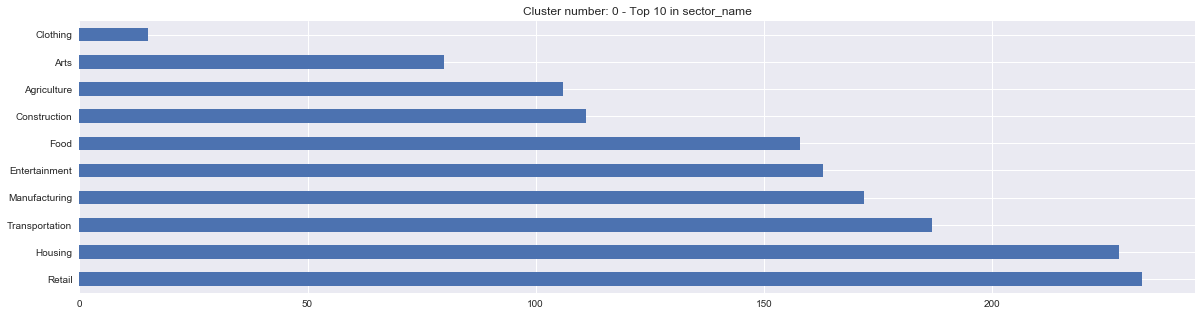

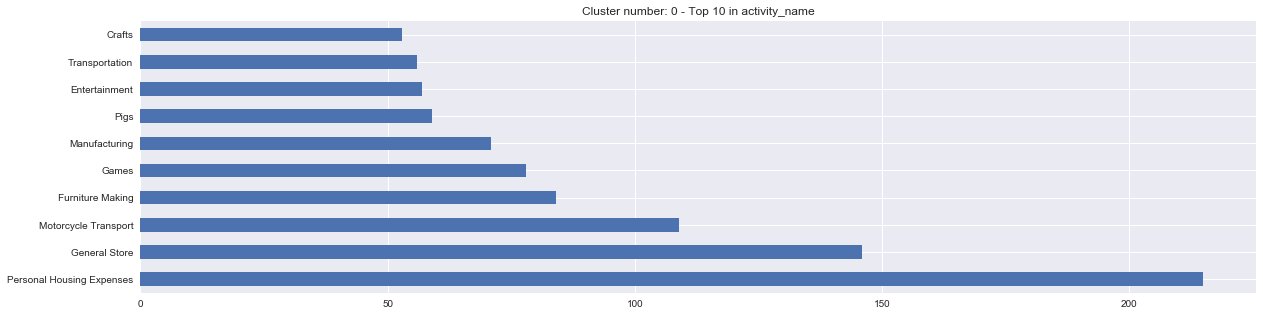

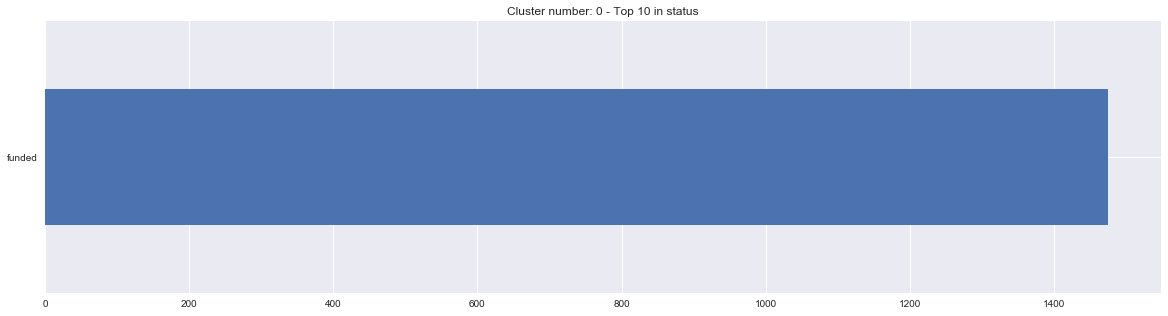

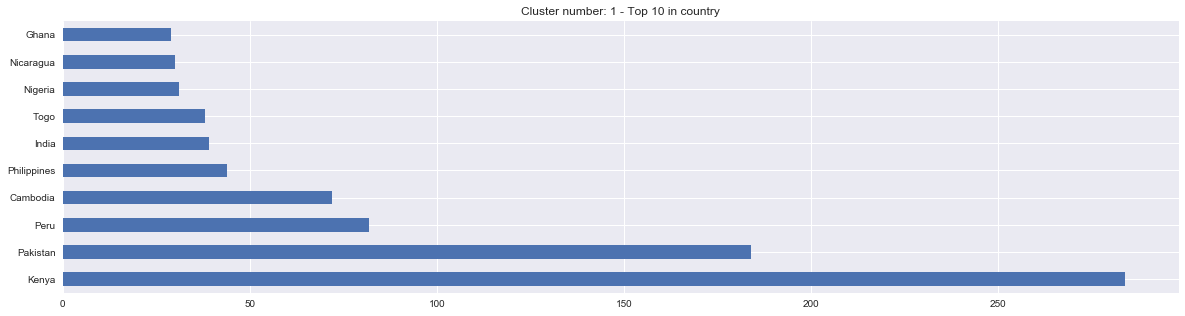

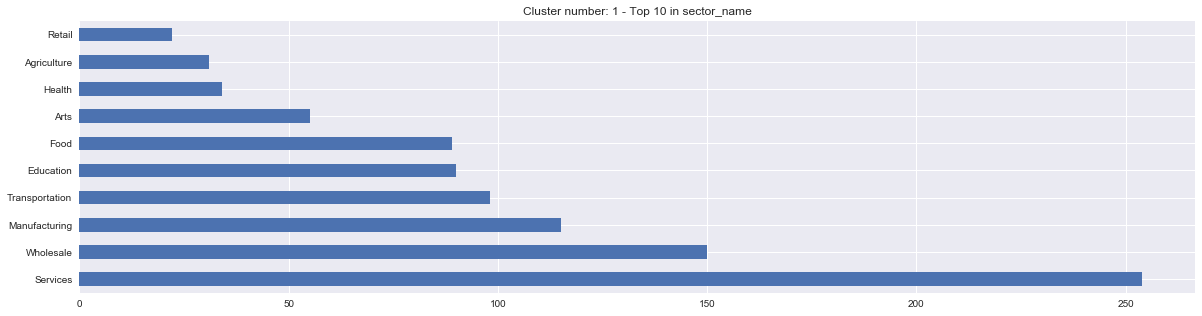

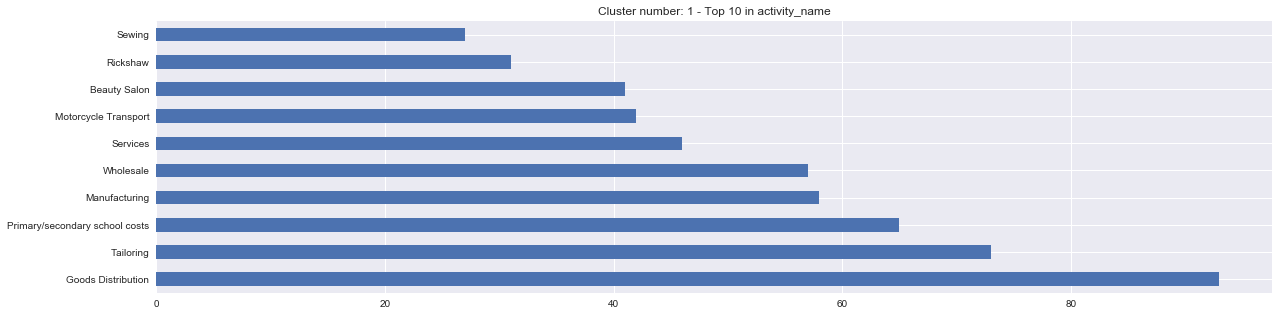

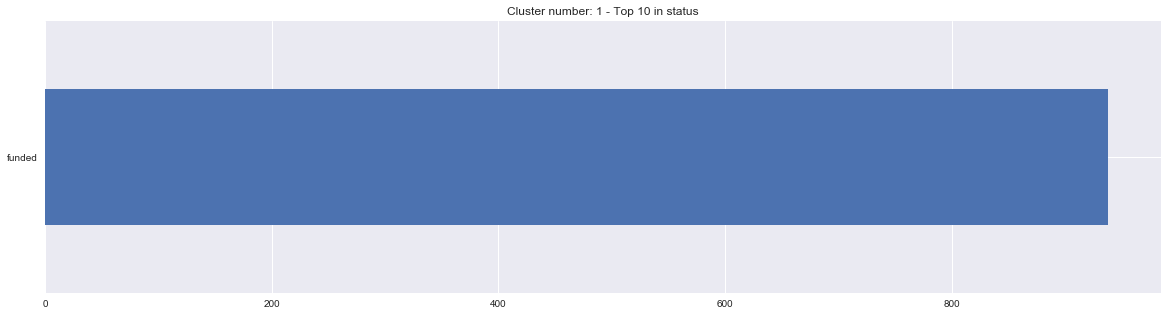

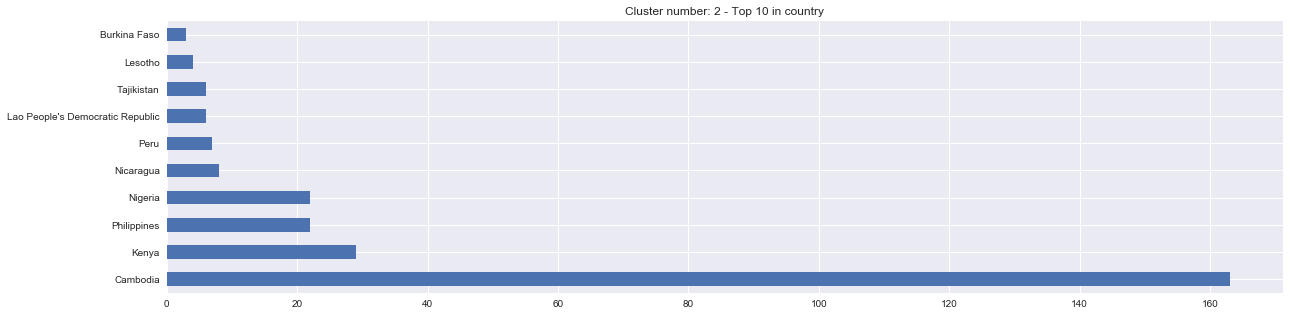

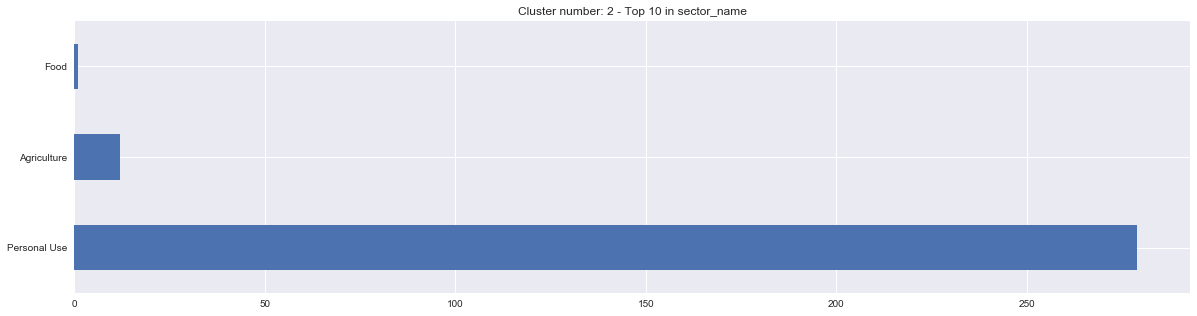

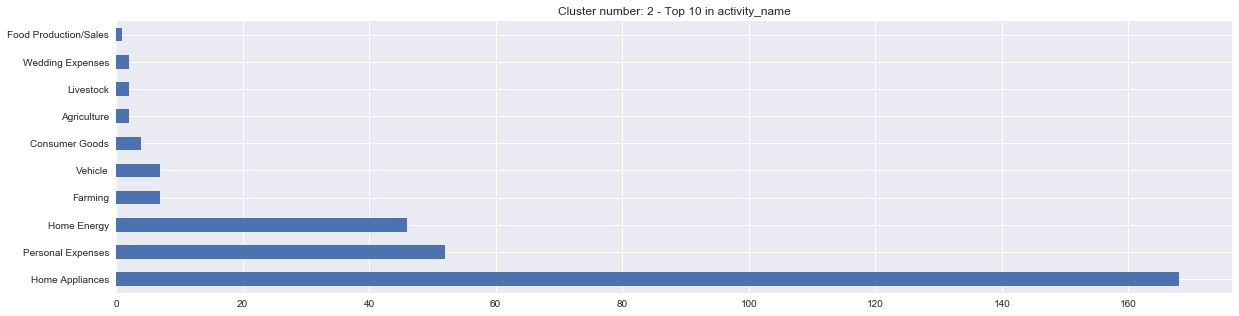

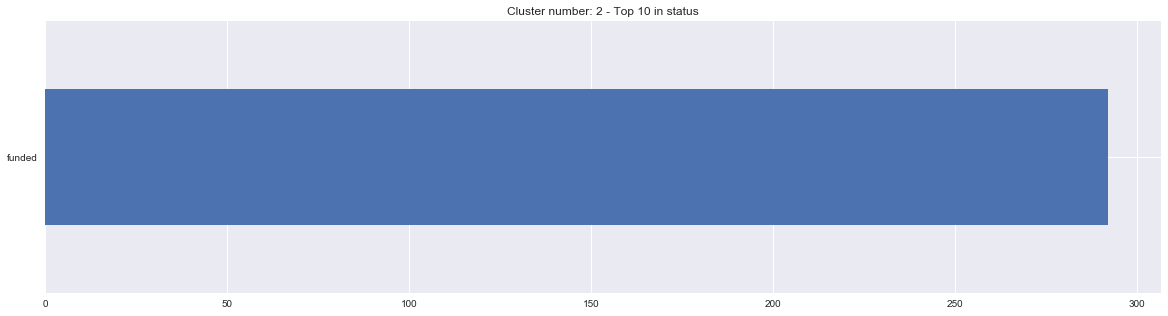

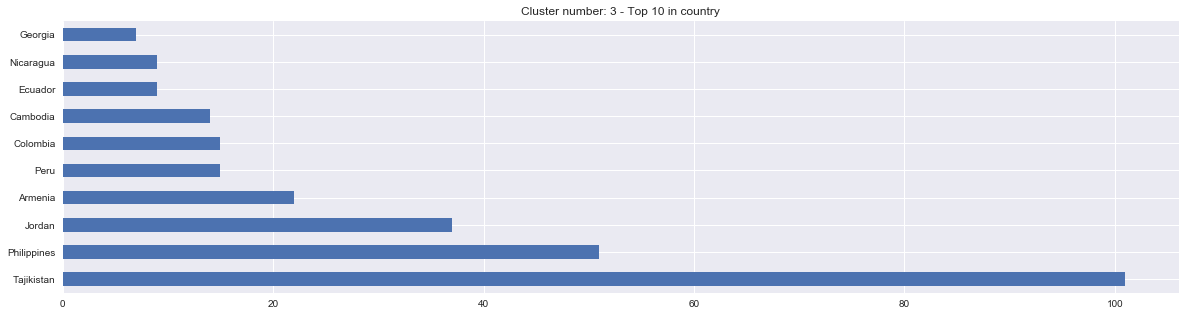

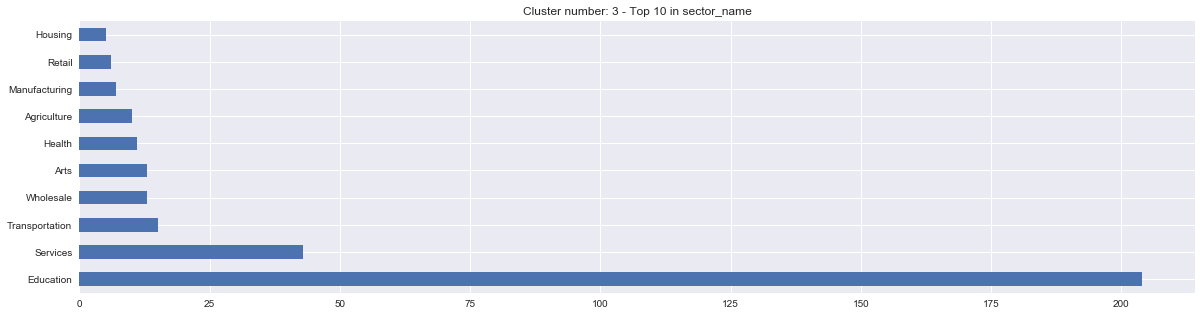

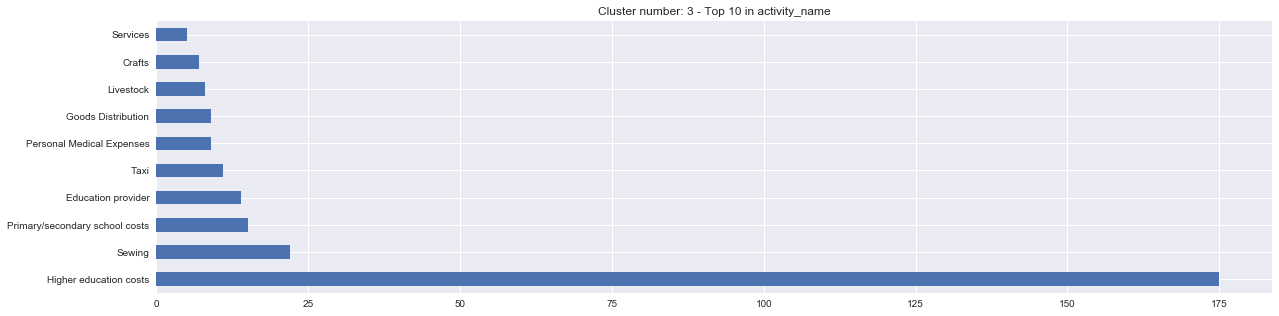

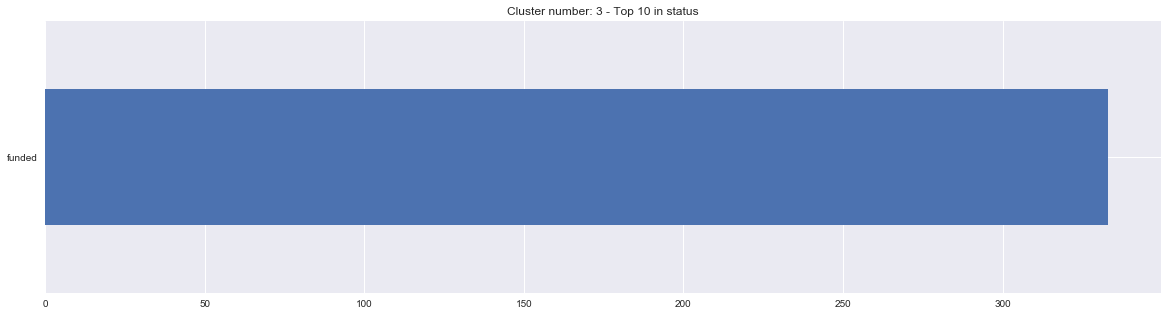


Training Sample - Numerical categorical

-----------------------------------------------


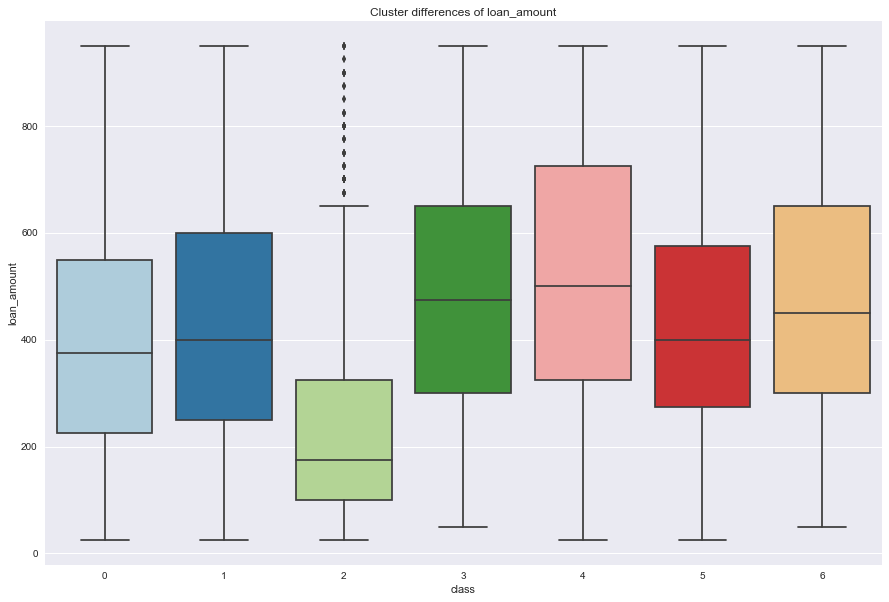

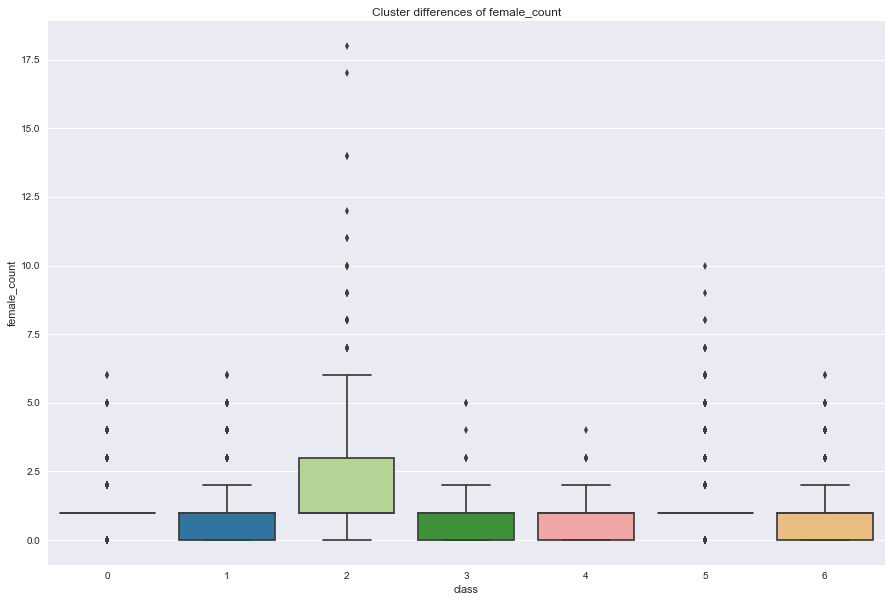

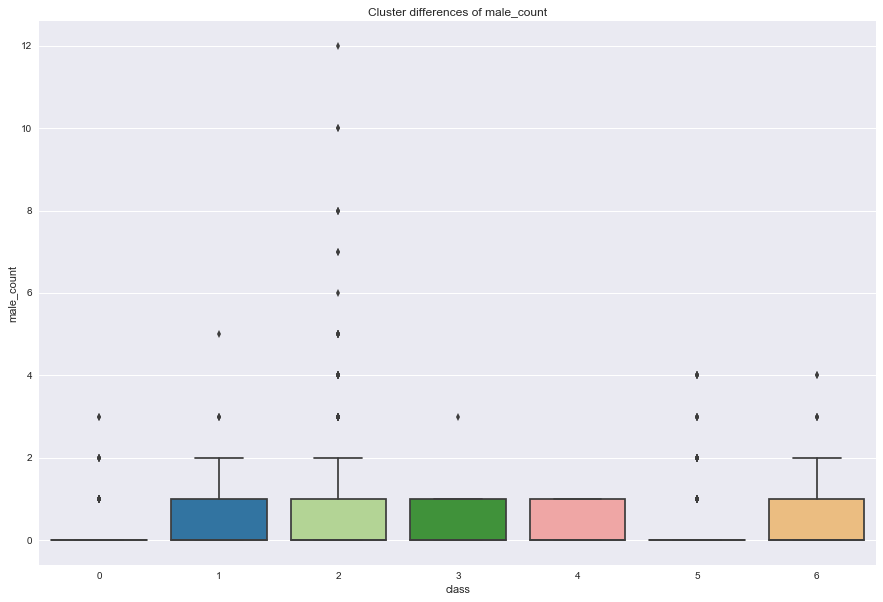

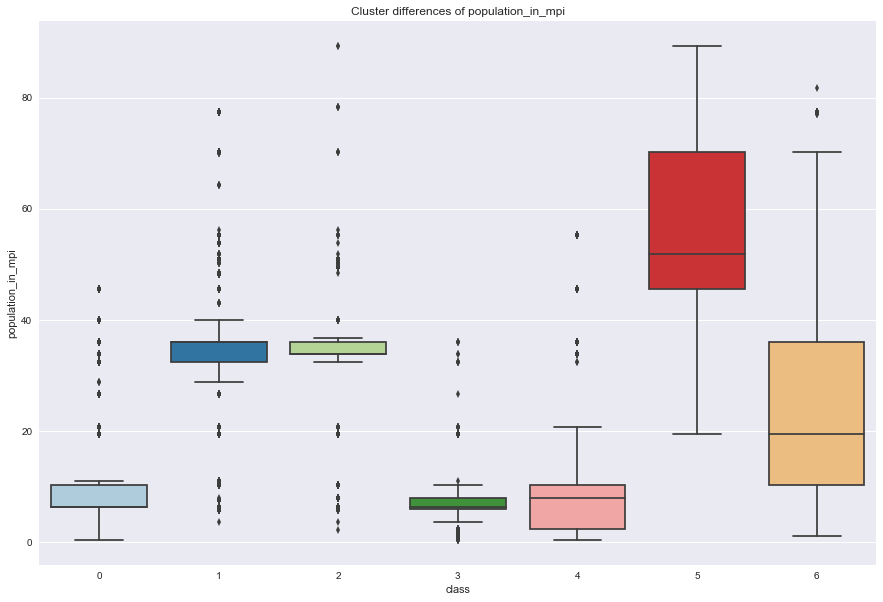

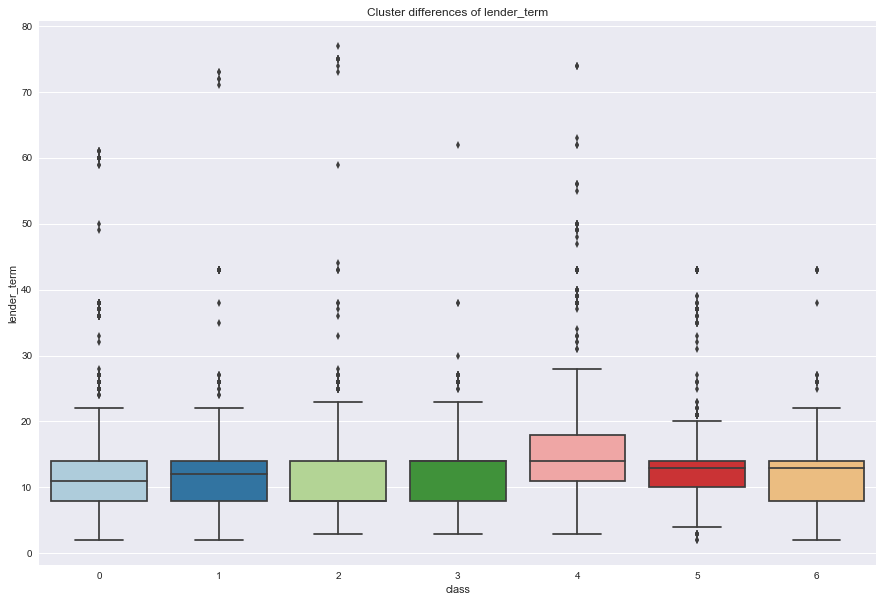

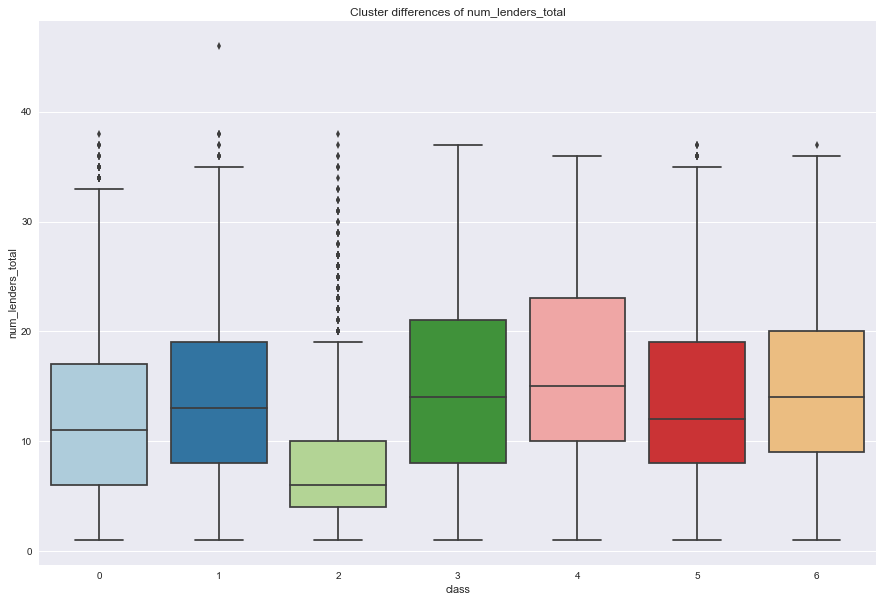

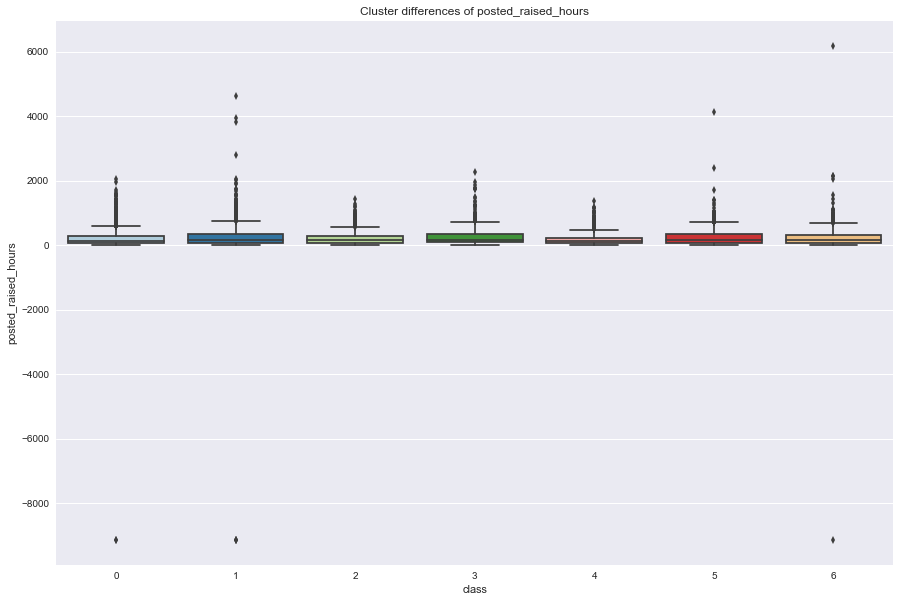

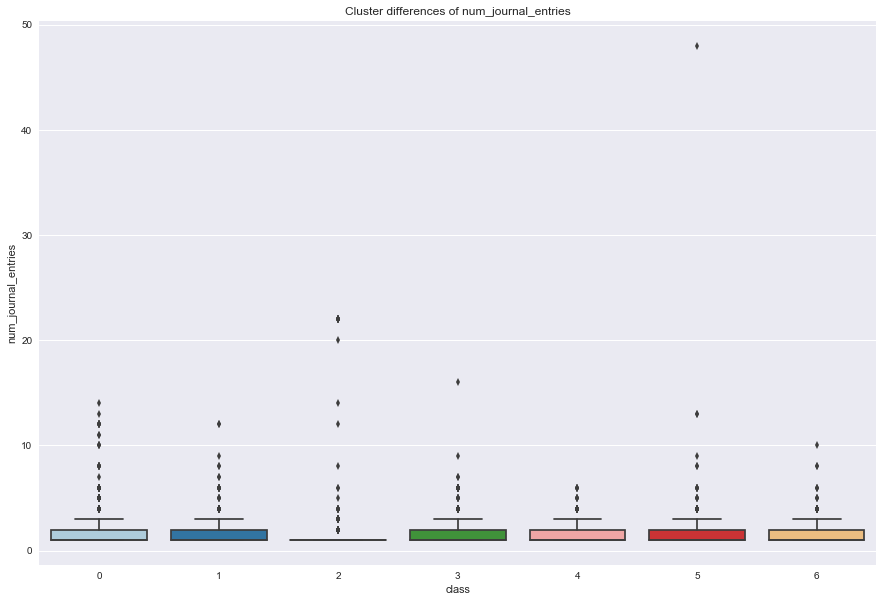


Test Sample - Numerical categorical

-----------------------------------------------


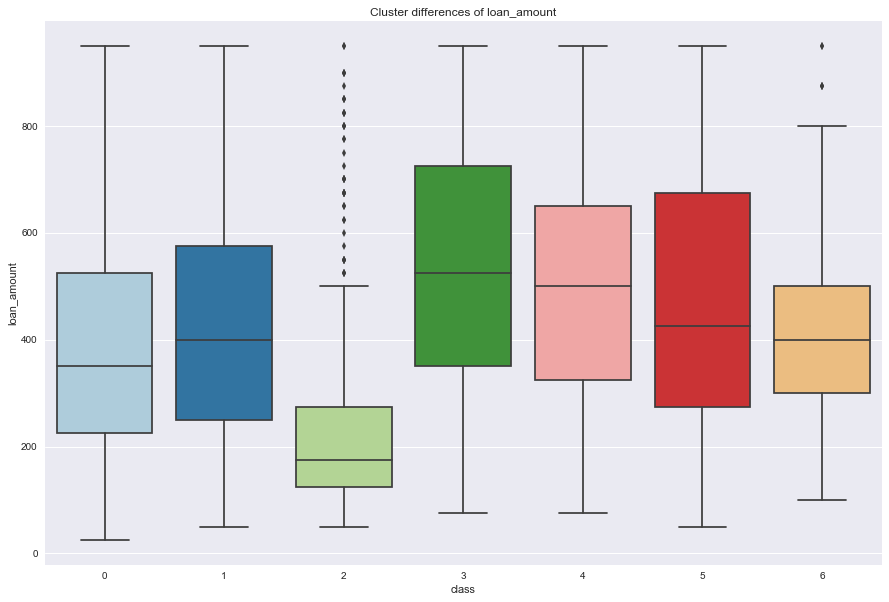

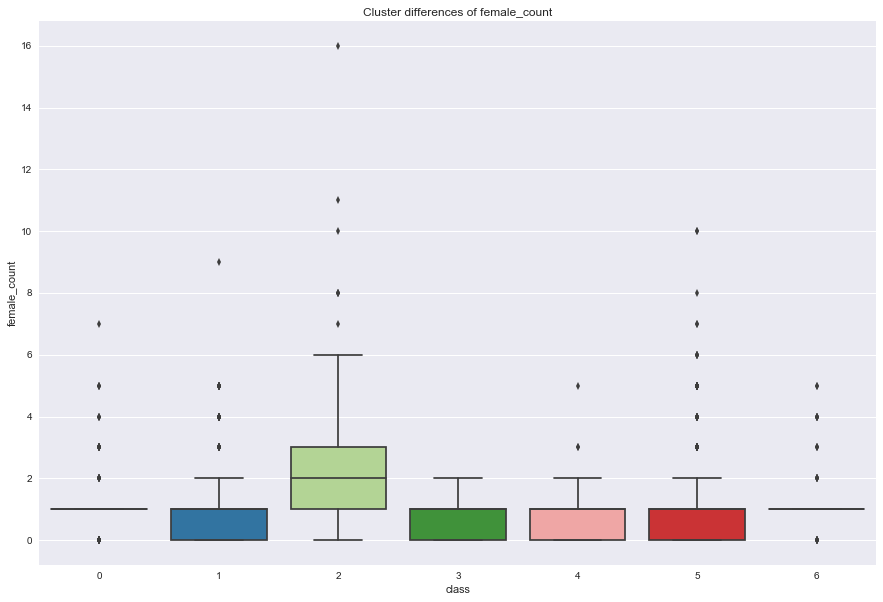

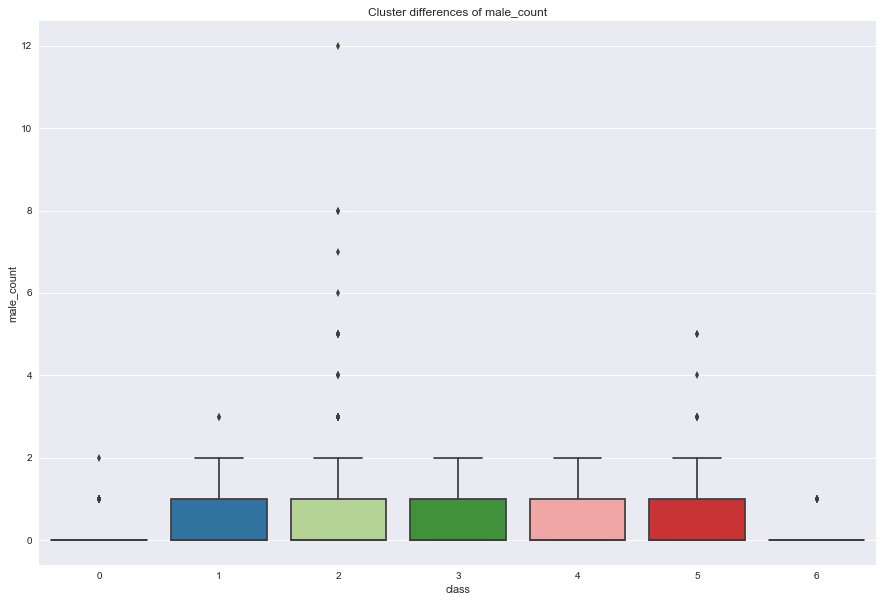

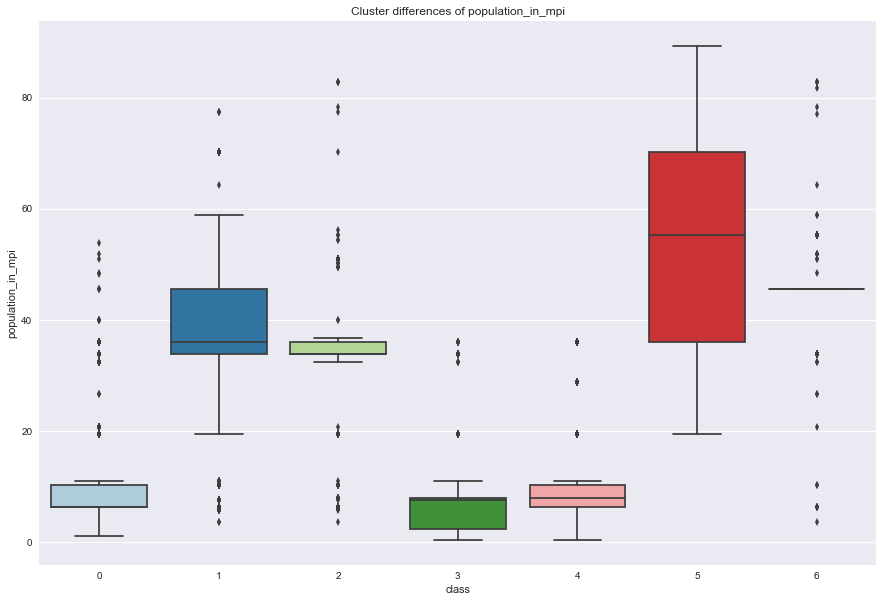

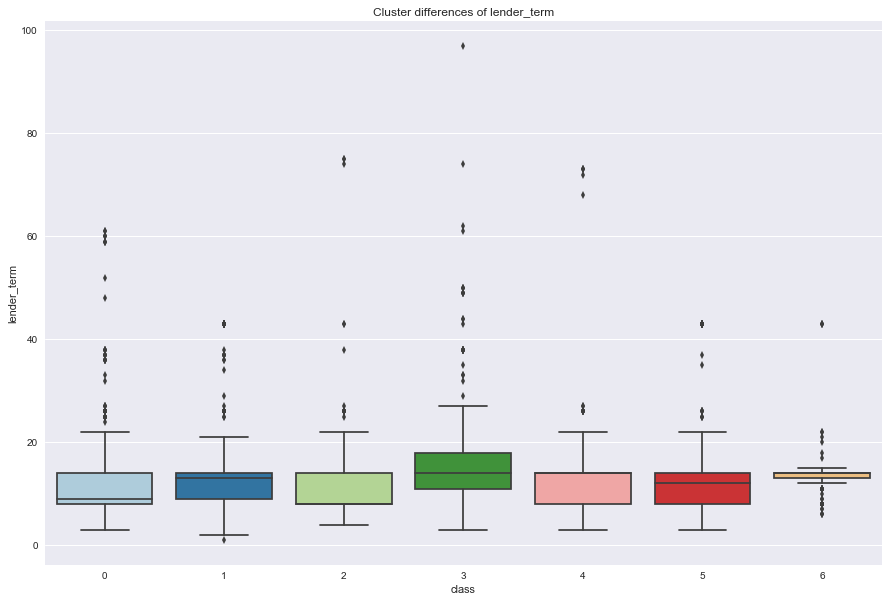

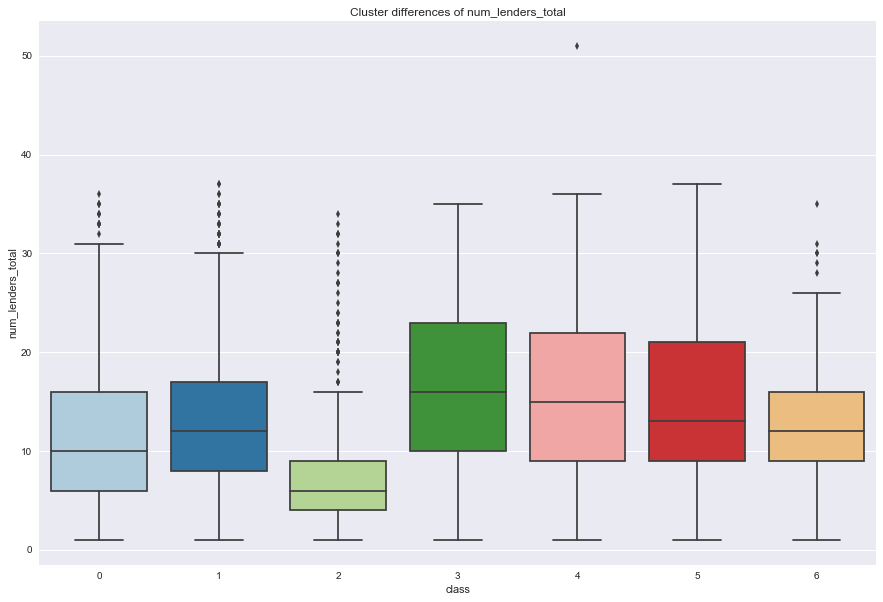

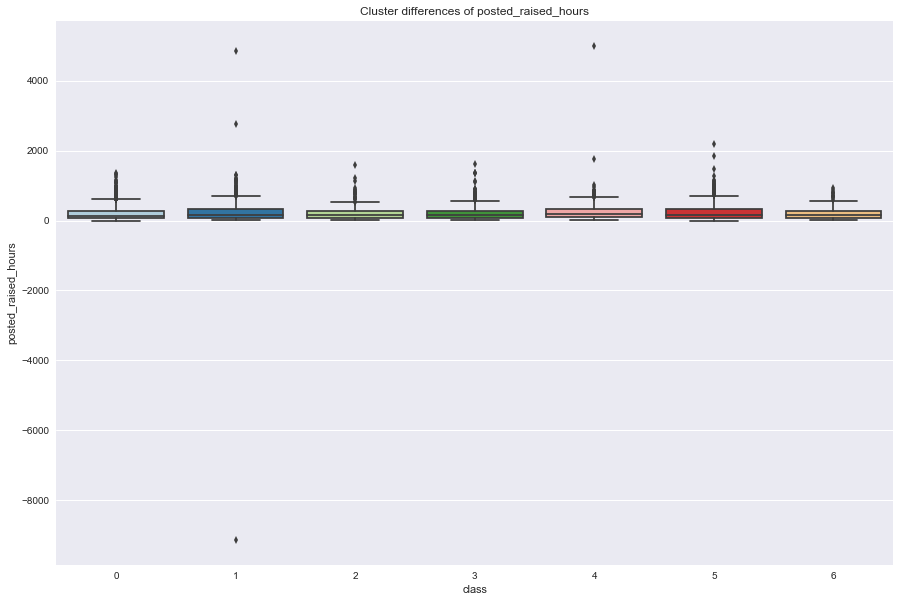

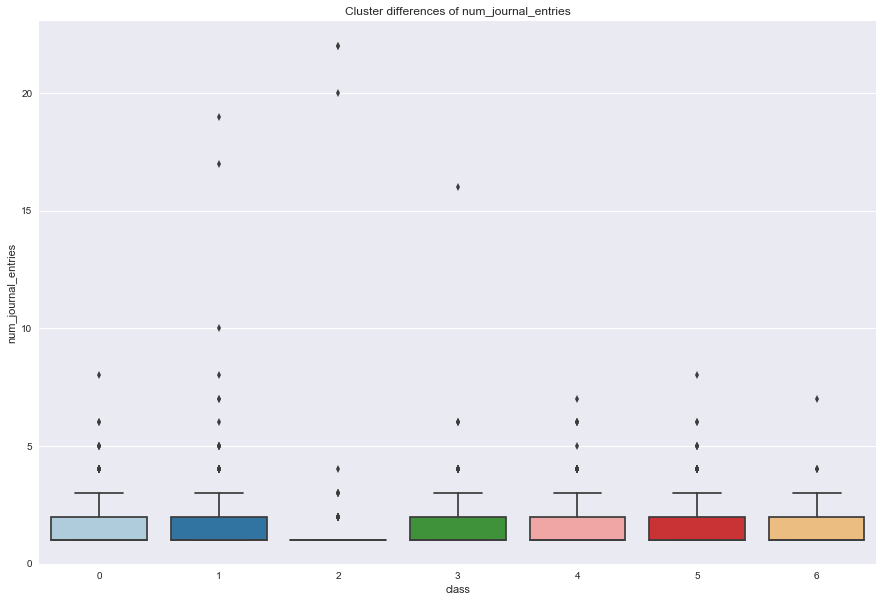

In [21]:
# Sticking with 3 component PCA to help visualize the clusters

def applyKMeansClustering(k,loan_samples):
    
    train_samples, test_samples = train_test_split(loans_samples,random_state=30)

    train_featured = getFeatureVector(train_samples)

    test_featured = getFeatureVector(test_samples)

    pca_transformed_train = applyPCA(k,train_featured)
    pca_transformed_test = applyPCA(k,test_featured)

    pca_clustered_train = pca_transformed_train
    
    pca_clustered_test = pca_transformed_test

    kmeans = KMeans(n_clusters=7, random_state=42).fit(pca_transformed_train)

    label = kmeans.labels_
    predicted = kmeans.predict(pca_transformed_test)
    
    
    pca_clustered_train['y'] = label
    
    pca_clustered_test['y'] = predicted
    
    print('\nTraining Sample')
    
    plotClusters(k,pca_clustered_train)
    
    print('\nTest Sample')
    
    plotClusters(k,pca_clustered_test)
    
    # Get train & test class info

    train_samples_clustered = train_samples
    test_samples_clustered = test_samples
    
    train_samples_clustered['class'] = label
    test_samples_clustered['class'] =  predicted
    
    print('\nTraining Sample - Describing categorical')
    
    print('\n-----------------------------------------------')
    
    plot_categorical(train_samples_clustered)
    
    
    print('\nTest Sample - Describing categorical')
    
    print('\n-----------------------------------------------')
    
    plot_categorical(test_samples_clustered)
    
    print('\nTraining Sample - Numerical categorical')
    
    print('\n-----------------------------------------------')
    
    plot_numerical(train_samples_clustered)
    
    
    print('\nTest Sample - Numerical categorical')
    
    print('\n-----------------------------------------------')
    
    plot_numerical(test_samples_clustered)
    
    list_pickle_path = f'Kiva_{k}_Clusters.pkl'
    list_pickle = open(list_pickle_path, 'wb')

    pickle.dump(kmeans, list_pickle)
    list_pickle.close()
    
    return train_samples_clustered.append(test_samples_clustered)


loan_samples_clustered = applyKMeansClustering(n_clusters,loans_samples) 

loan_samples_clustered.to_csv('Clustered_samples_dataset.csv')

In [22]:
def getLatestLoans():
    response = requests.get('http://api.kivaws.org/v1/loans/newest.json').json()
    loan_items = response['loans']

    new_loans_dictionary = []

    for loan in loan_items:
        new_item = {
            'loan_amount': loan['loan_amount'],
            'status': loan['status'],
            'activity_name': loan['activity'],
            'sector_name': loan['sector'],
            'borrower_count': loan['borrower_count'],
            'country_name': loan['location']['country'].lower()
        }

        new_loans_dictionary.append(new_item)

    new_loans_df = pd.DataFrame(new_loans_dictionary)

    new_loans_df = new_loans_df.rename(columns={'country_name':'country'})

    mpi = pd.read_csv('mpi.csv',encoding='latin-1')

    mpi_reduced = mpi[['country','mpi','population_in_mpi','Education','Health','Living standards','population_in_severe_mpi']]
    mpi_reduced.to_csv('mpi.csv',encoding='utf-8')

    merged = new_loans_df.merge(mpi_reduced,on='country')

    return merged

In [23]:
getLatestLoans()

,activity_name,borrower_count,country,loan_amount,sector_name,status,mpi,population_in_mpi,Education,Health,Living standards,population_in_severe_mpi
0,Farming,2,cambodia,1200,Agriculture,fundraising,0.150,33.8,30.8,26.4,42.8,11.4
1,Blacksmith,1,cambodia,500,Manufacturing,fundraising,0.150,33.8,30.8,26.4,42.8,11.4
2,Sewing,1,pakistan,525,Services,fundraising,0.237,45.6,36.2,32.3,31.6,26.5
3,Tailoring,1,pakistan,225,Services,fundraising,0.237,45.6,36.2,32.3,31.6,26.5
4,Fuel/Firewood,1,pakistan,450,Retail,fundraising,0.237,45.6,36.2,32.3,31.6,26.5
5,Wholesale,1,pakistan,275,Wholesale,fundraising,0.237,45.6,36.2,32.3,31.6,26.5
6,Personal Medical Expenses,1,tajikistan,625,Health,fundraising,0.031,7.9,13.4,52.6,34.0,1.2
7,Sewing,1,tajikistan,250,Services,fundraising,0.031,7.9,13.4,52.6,34.0,1.2
8,Sewing,1,tajikistan,1375,Services,fundraising,0.031,7.9,13.4,52.6,34.0,1.2
9,Home Energy,1,kenya,100,Personal Use,fundraising,0.166,36.0,12.3,32.2,55.5,10.7


In [24]:
def describe_numerical(df):
    stats = pd.DataFrame()
        
    for k in range(n_clusters):  

        kth_cluster = df[df['class']==k]
        
        kth_stats = df[['loan_amount','female_count', 
                          'male_count','population_in_mpi',
                          'lender_term', 'num_lenders_total', 
                          'posted_raised_hours','num_journal_entries'
                       ]].describe().transpose()
        
    stats = stats.append(kth_stats)   
        
    return stats[['mean','50%']]

In [25]:
def describe_categorical(df):

    cluster_frequency = []

    for k in range(n_clusters):
        kth_cluster = df[df['class']==k]

        category_values = {
            str(k) : {}
        }

        for c in ['country','sector_name','activity_name','status']:
            cat_values = kth_cluster[c].value_counts().head(10).to_dict()
            category_values[str(k)].update({str(c):cat_values})

        cluster_frequency.append(category_values)
        
    return cluster_frequency

In [26]:
describe_numerical(loan_samples_clustered)

,mean,50%
loan_amount,427.140067,400.0
female_count,0.919379,1.0
male_count,0.308668,0.0
population_in_mpi,26.018009,19.4
lender_term,12.607315,12.0
num_lenders_total,13.285172,12.0
posted_raised_hours,233.842213,148.0
num_journal_entries,1.490687,1.0


In [27]:
describe_categorical(loan_samples_clustered)

[{'0': {'activity_name': {'Crafts': 288,
    'Entertainment': 243,
    'Furniture Making': 293,
    'Games': 281,
    'General Store': 555,
    'Manufacturing': 321,
    'Motorcycle Transport': 389,
    'Personal Housing Expenses': 936,
    'Transportation': 201,
    'Weaving': 202},
   'country': {'Cambodia': 301,
    'Colombia': 362,
    'Ecuador': 99,
    'Ghana': 74,
    'Indonesia': 119,
    'Mexico': 173,
    'Nicaragua': 520,
    'Peru': 743,
    'Philippines': 3017,
    'Tajikistan': 75},
   'sector_name': {'Arts': 607,
    'Construction': 111,
    'Entertainment': 666,
    'Food': 643,
    'Housing': 995,
    'Manufacturing': 727,
    'Retail': 882,
    'Services': 262,
    'Transportation': 690,
    'Wholesale': 110},
   'status': {'funded': 5816}}},
 {'1': {'activity_name': {'Beauty Salon': 88,
    'Clothing Sales': 408,
    'Farming': 238,
    'Goods Distribution': 231,
    'Motorcycle Transport': 148,
    'Pharmacy': 155,
    'Services': 107,
    'Tailoring': 127,
    'Use

In [17]:
def plot_numerical(df):
    for c in ['loan_amount','female_count', 'male_count','population_in_mpi',
              'lender_term', 'num_lenders_total', 'posted_raised_hours','num_journal_entries']:

        plt.figure(figsize=(15,10))

        sns.boxplot(x="class", y=c, data=df, palette="Paired")

        plt.title(f'Cluster differences of {c}')

        plt.savefig(f'Cluster_numerical_{c}.png')

        plt.show()
    
    stats = pd.DataFrame()

In [18]:
def plot_categorical(df):

    for k in range(n_clusters):
        kth_cluster = df[df['class']==k]

        for c in ['country','sector_name','activity_name','status']:
            plt.figure(figsize=(20,5))
            cat_values = kth_cluster[c].value_counts().head(10).to_dict()
            kth_cluster[c].value_counts().head(10).plot(kind='barh')
            
            plt.title(f'Cluster number: {k} - Top 10 in {c}')
            plt.savefig(f'cluster_category_{c}.png')
            plt.show()            
        

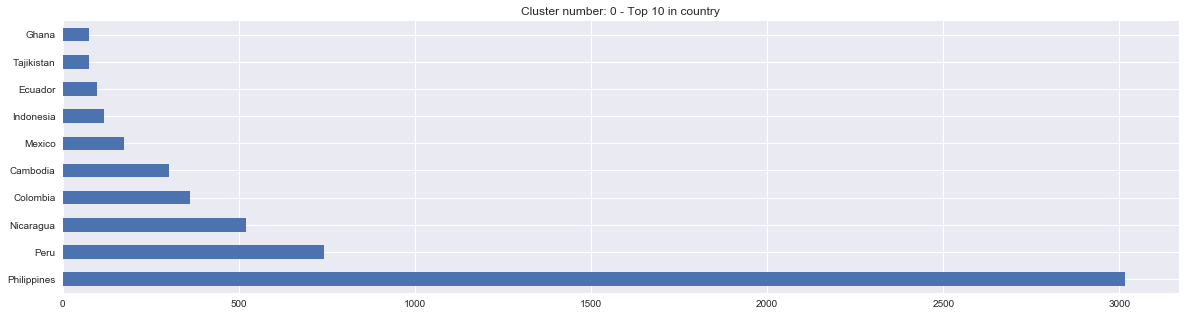

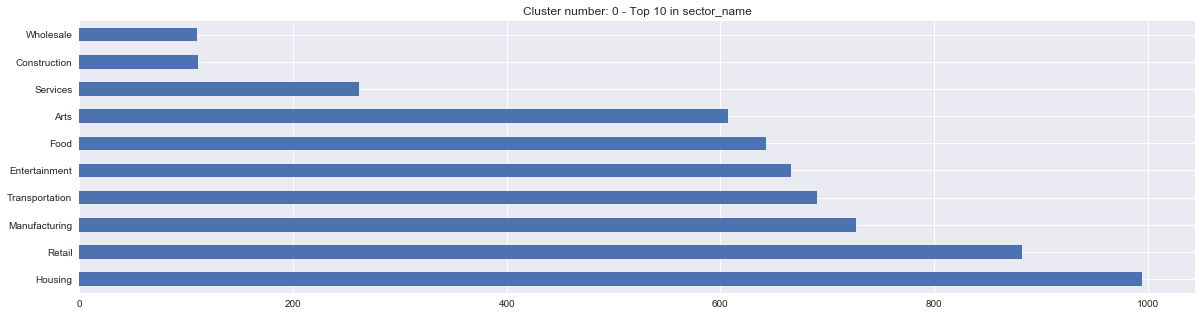

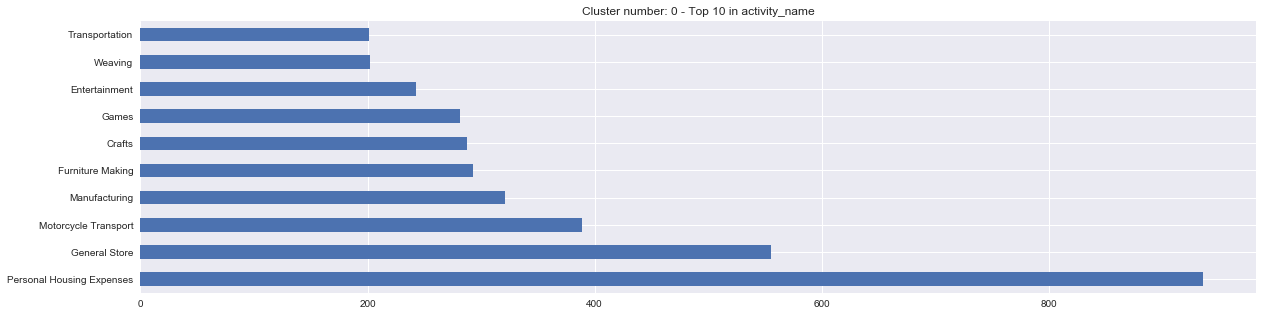

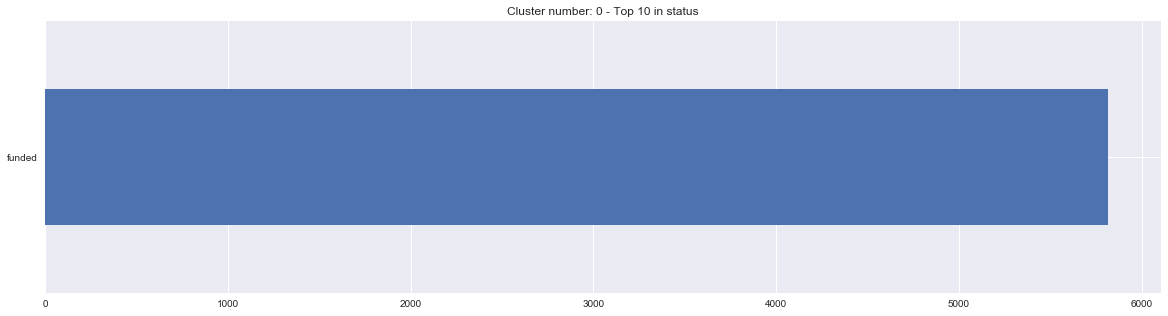

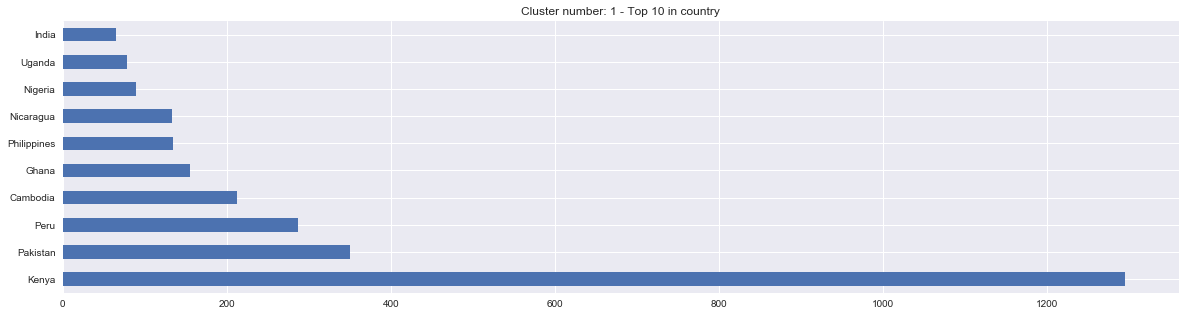

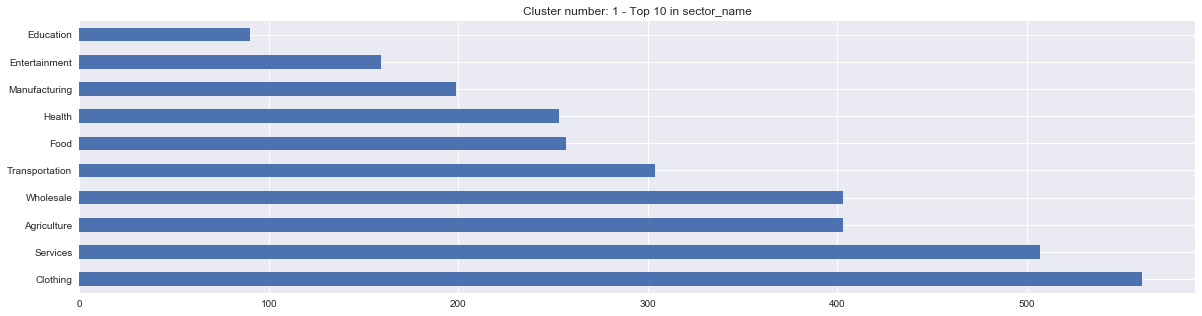

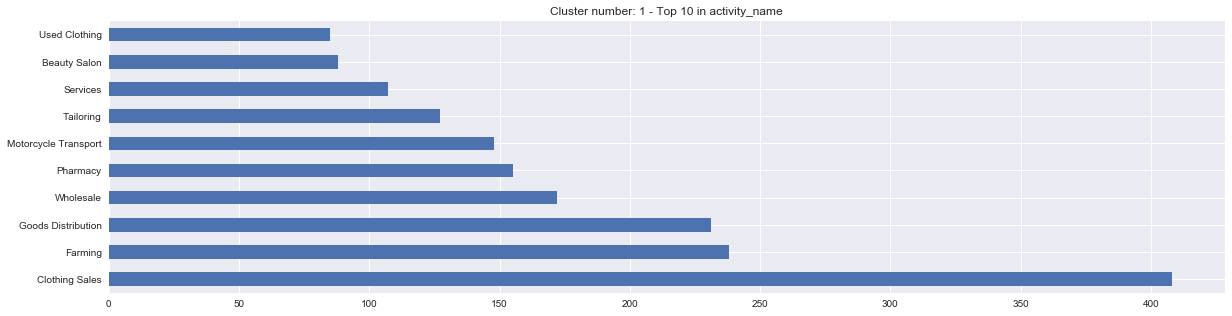

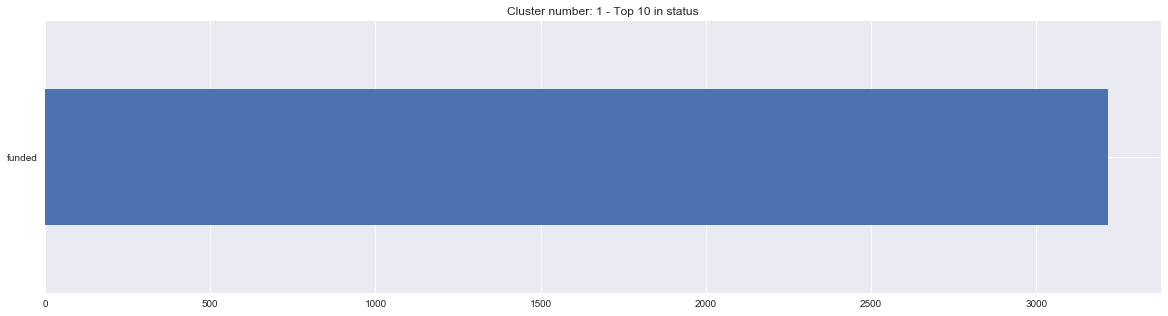

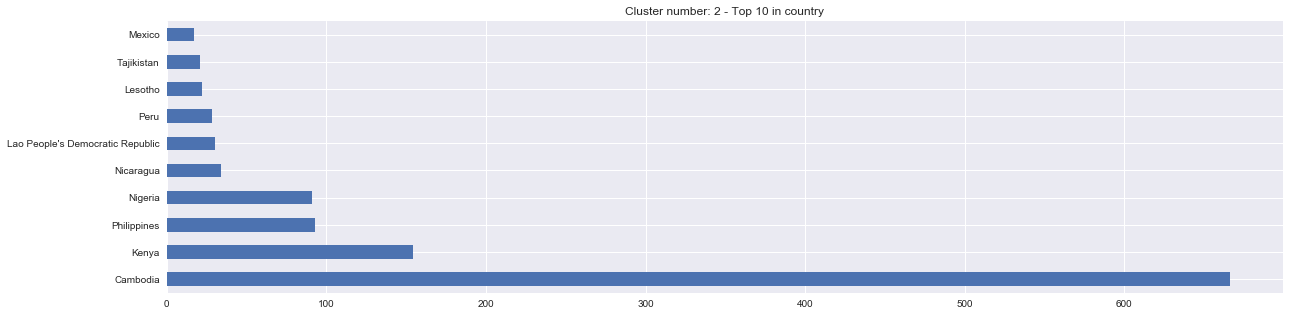

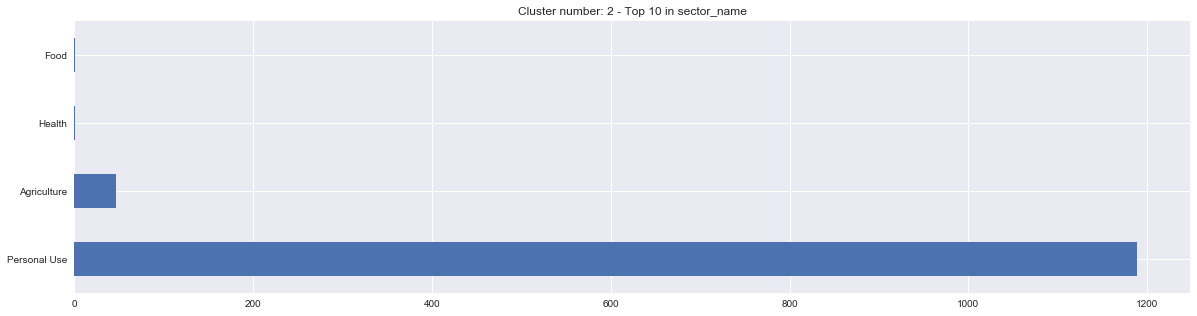

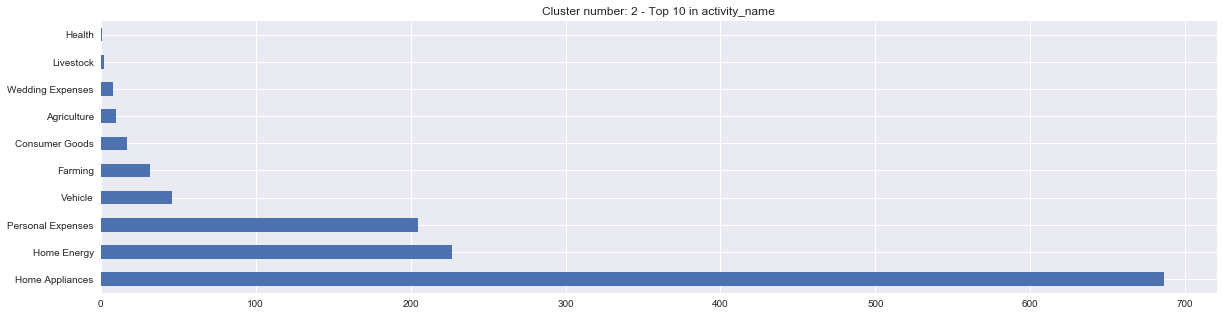

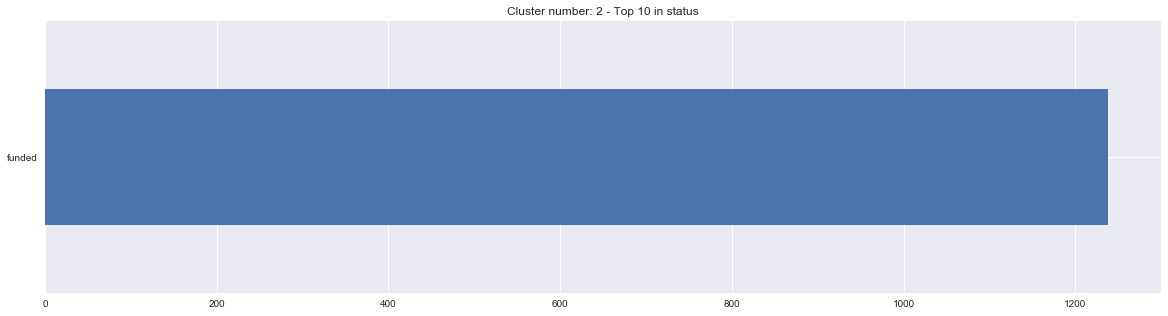

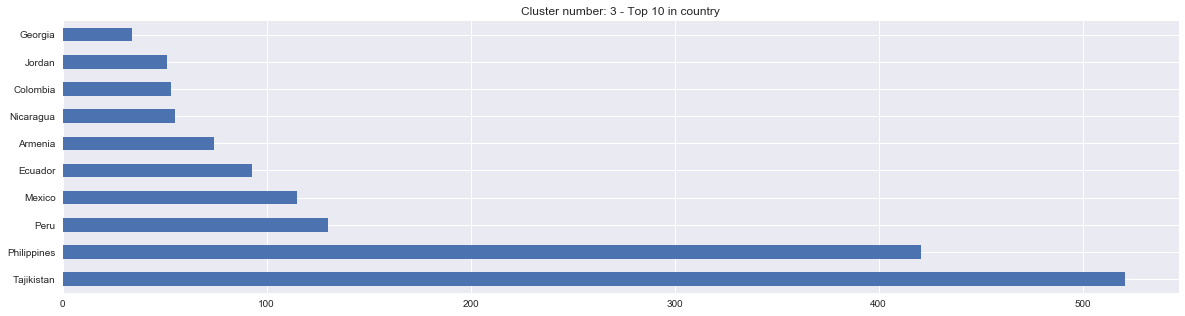

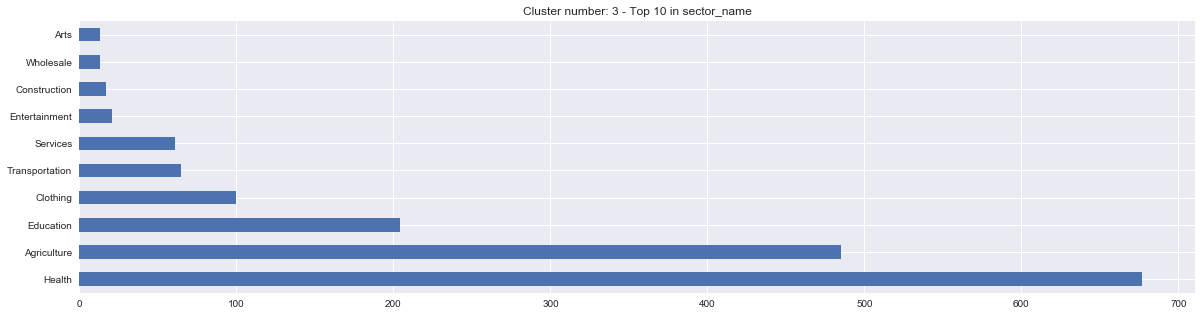

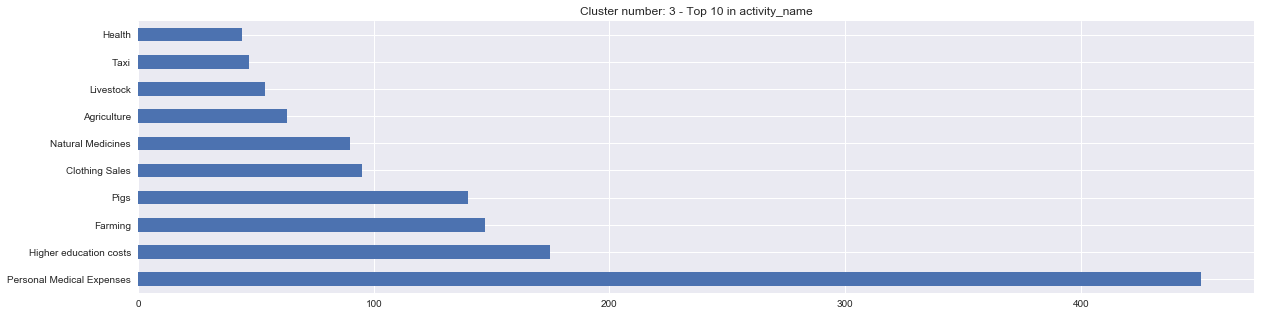

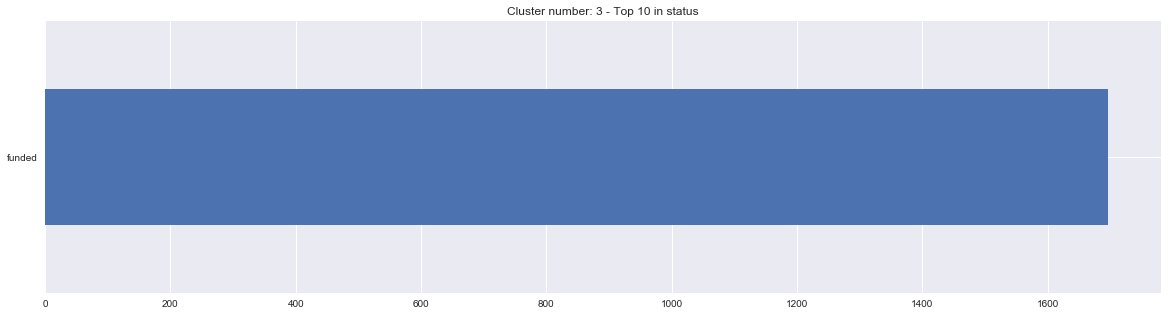

In [28]:
plot_categorical(loan_samples_clustered)

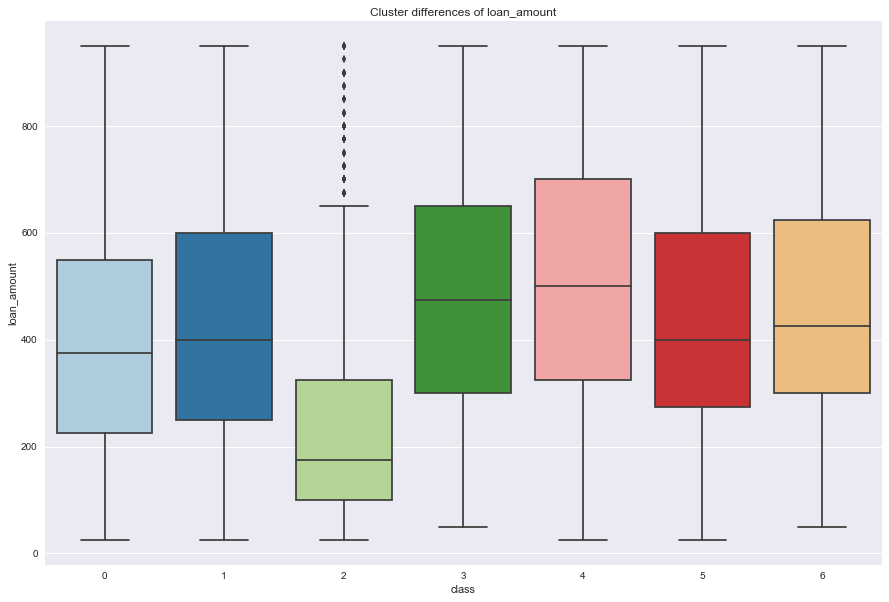

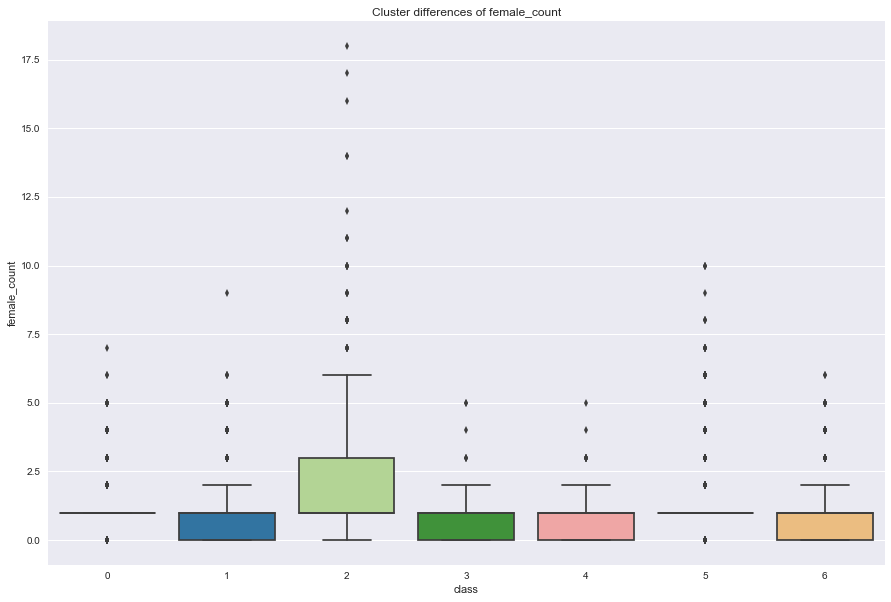

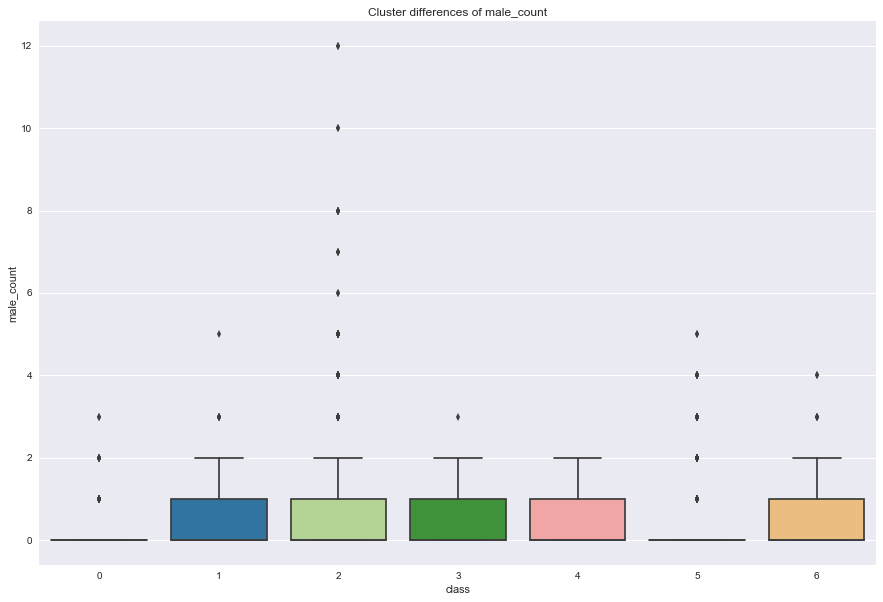

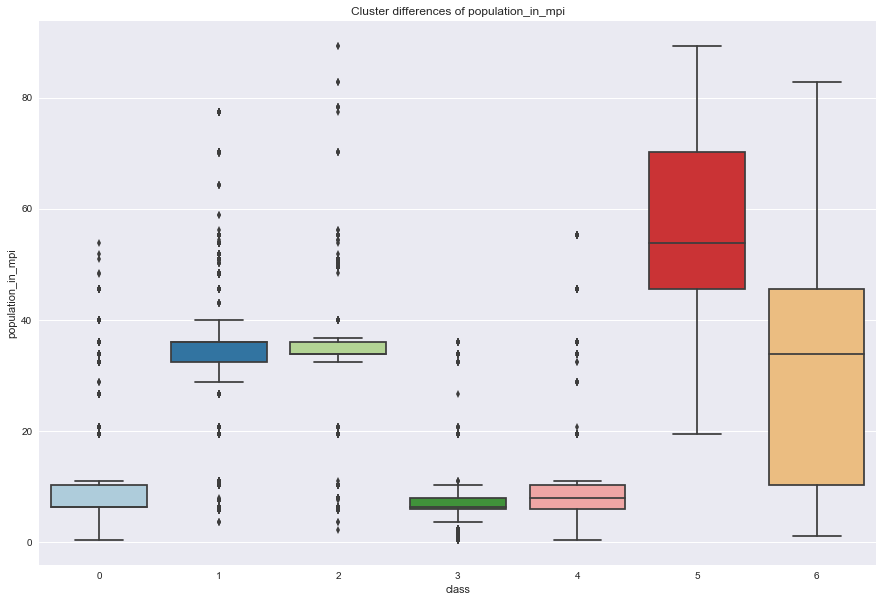

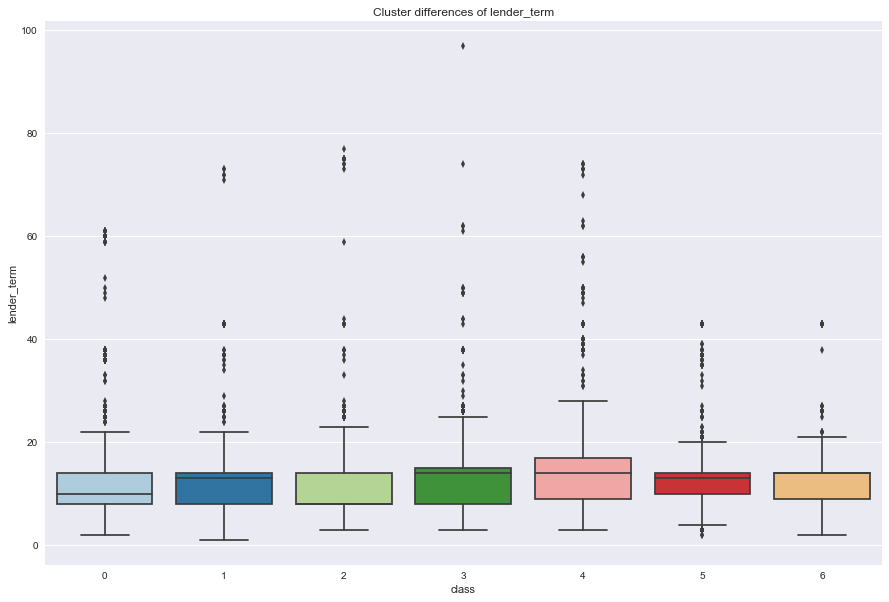

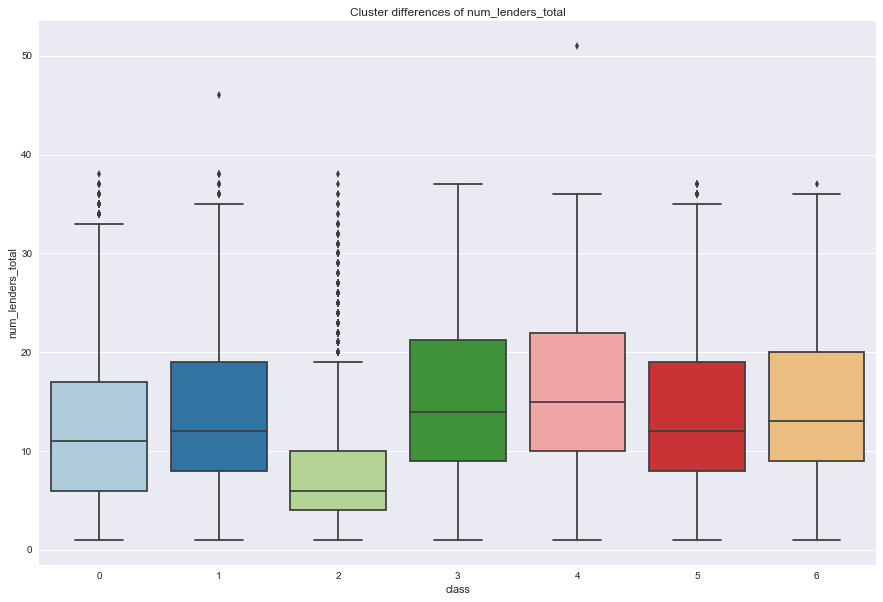

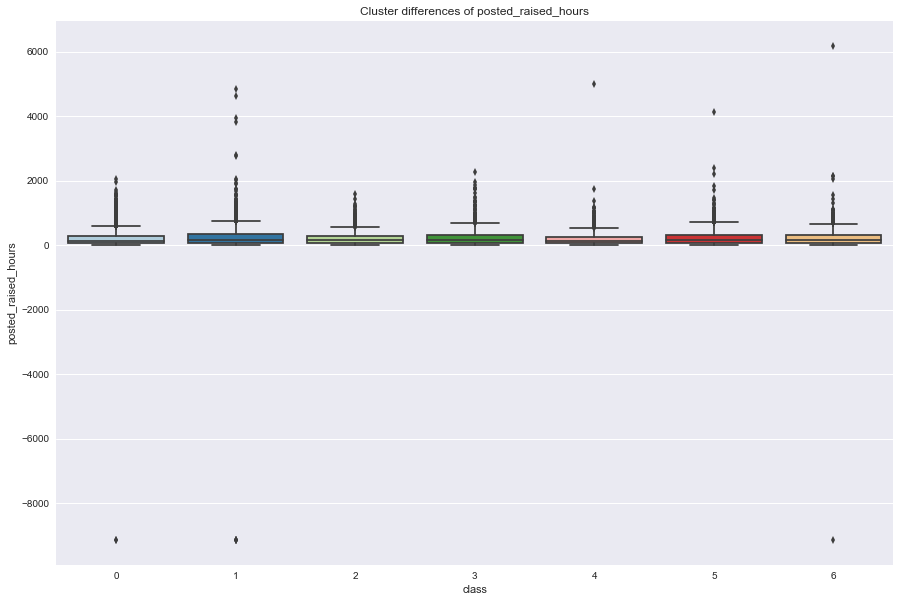

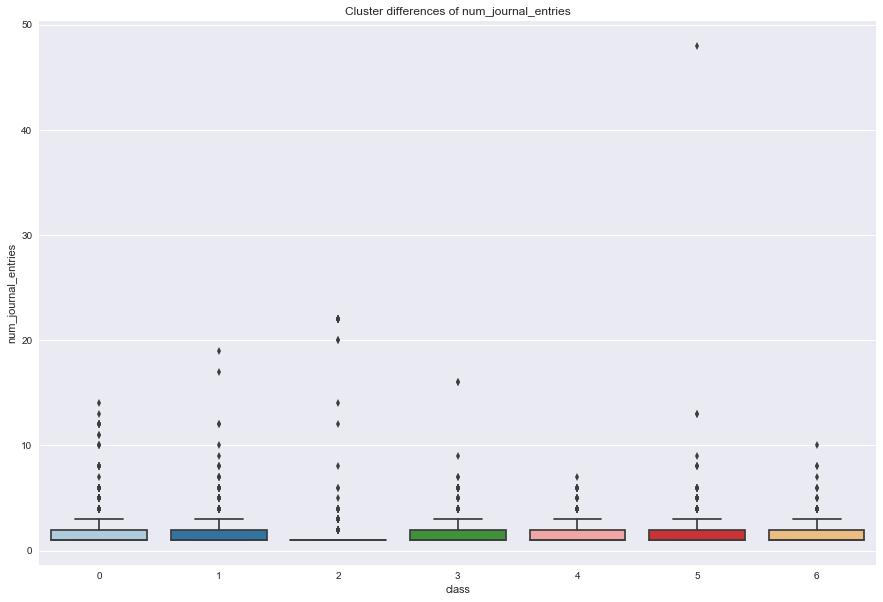

In [29]:
plot_numerical(loan_samples_clustered)

In [30]:
merged_ds = getLatestLoans()

In [31]:
getFeatureVector(merged_ds)

,loan_amount,borrower_count,mpi,population_in_mpi,Education,Health,Living standards,population_in_severe_mpi,status_fundraising,activity_name_Blacksmith,...,activity_name_Tailoring,activity_name_Wholesale,sector_name_Agriculture,sector_name_Clothing,sector_name_Health,sector_name_Manufacturing,sector_name_Personal Use,sector_name_Retail,sector_name_Services,sector_name_Wholesale
0,1.032676,0.950255,0.327279,0.509169,0.506548,-0.775471,0.547586,0.036799,0.0,-0.267261,...,-0.267261,-0.267261,2.0,-0.267261,-0.267261,-0.267261,-0.267261,-0.5,-0.603023,-0.267261
1,-0.384723,-0.345547,0.327279,0.509169,0.506548,-0.775471,0.547586,0.036799,0.0,3.741657,...,-0.267261,-0.267261,-0.5,-0.267261,-0.267261,3.741657,-0.267261,-0.5,-0.603023,-0.267261
2,-0.334101,-0.345547,1.313652,1.204027,1.012472,-0.364272,-0.529633,1.525171,0.0,-0.267261,...,-0.267261,-0.267261,-0.5,-0.267261,-0.267261,-0.267261,-0.267261,-0.5,1.658312,-0.267261
3,-0.941558,-0.345547,1.313652,1.204027,1.012472,-0.364272,-0.529633,1.525171,0.0,-0.267261,...,3.741657,-0.267261,-0.5,-0.267261,-0.267261,-0.267261,-0.267261,-0.5,1.658312,-0.267261
4,-0.485965,-0.345547,1.313652,1.204027,1.012472,-0.364272,-0.529633,1.525171,0.0,-0.267261,...,-0.267261,-0.267261,-0.5,-0.267261,-0.267261,-0.267261,-0.267261,2.0,-0.603023,-0.267261
5,-0.840315,-0.345547,1.313652,1.204027,1.012472,-0.364272,-0.529633,1.525171,0.0,-0.267261,...,-0.267261,3.741657,-0.5,-0.267261,-0.267261,-0.267261,-0.267261,-0.5,-0.603023,3.741657
6,-0.131616,-0.345547,-1.021897,-1.015983,-1.123650,1.050534,-0.298800,-0.968592,0.0,-0.267261,...,-0.267261,-0.267261,-0.5,-0.267261,3.741657,-0.267261,-0.267261,-0.5,-0.603023,-0.267261
7,-0.890937,-0.345547,-1.021897,-1.015983,-1.123650,1.050534,-0.298800,-0.968592,0.0,-0.267261,...,-0.267261,-0.267261,-0.5,-0.267261,-0.267261,-0.267261,-0.267261,-0.5,1.658312,-0.267261
8,1.387026,-0.345547,-1.021897,-1.015983,-1.123650,1.050534,-0.298800,-0.968592,0.0,-0.267261,...,-0.267261,-0.267261,-0.5,-0.267261,-0.267261,-0.267261,-0.267261,-0.5,1.658312,-0.267261
9,-1.194665,-0.345547,0.508681,0.638719,-1.226709,-0.371241,1.769075,-0.032199,0.0,-0.267261,...,-0.267261,-0.267261,-0.5,-0.267261,-0.267261,-0.267261,3.741657,-0.5,-0.603023,-0.267261
